##### Import Libraries

In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder 
from imblearn.over_sampling import SMOTE ,BorderlineSMOTE, SVMSMOTE, SMOTENC,ADASYN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.svm import SVC 
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC 
import lightgbm as ltb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

##### Load initial dataset

In [344]:
print("This table contains information about all the customers regarding their socio-economic status ")
application_record = pd.read_csv('datasets/application_record.csv')
application_record.head(5)

This table contains information about all the customers regarding their socio-economic status 


ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

In [345]:
print("This table contains all the payment/default records for a given client.")
credit_record = pd.read_csv('datasets/credit_record.csv')
credit_record.head(5)


This table contains all the payment/default records for a given client.


ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C

#### Important info

**Company Name:**

Credit Card Company<br><br>
**Problem Type:**

Classification (Binary)
Problem:<br>

-Credit score cards are a common risk control method in the financial industry.<br>
-It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings.<br>
-The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.<br><br>
**Goal:**

Build a machine learning model to predict if an applicant is 'good' or 'bad' client.<br>
These details (features we will use to predict), will let us determine the target variable which is:<br>
Target (1=high risk, 0=low risk)


#### Take a peek at the data 

In [346]:
print("The application record has a shape of {} and contains information about {} unique clients (ID).".format(application_record.shape,application_record['ID'].nunique()))
print("On the other hand, the credit record has a shape of {} and contains information about {} unique clients (ID).".format(credit_record.shape,credit_record['ID'].nunique()))
print("This means that in order to create the necessary labels and to use information from both datasets for all instances, we need to keep only the common clients-IDs.")

The application record has a shape of (438557, 18) and contains information about 438510 unique clients (ID).
On the other hand, the credit record has a shape of (1048575, 3) and contains information about 45985 unique clients (ID).
This means that in order to create the necessary labels and to use information from both datasets for all instances, we need to keep only the common clients-IDs.


In [347]:
# find the common IDs from both datasets
# a set is a data structure in python that keeps only the unique elements. Can also use .unique()
common_IDs = set(application_record['ID']).intersection(set(credit_record['ID']))
print("The common clients in both datasets that will be used for further studying are {}.".format(len(common_IDs)))
# filter each dataset in order to keep only information about the selected IDs
application_record = application_record.loc[application_record['ID'].isin(common_IDs)]
credit_record = credit_record.loc[credit_record['ID'].isin(common_IDs)]
print("The new shape of each dataset now is {} for the application record and {} for the credit record.".format(application_record.shape,credit_record.shape))

The common clients in both datasets that will be used for further studying are 36457.
The new shape of each dataset now is (36457, 18) for the application record and (777715, 3) for the credit record.


In [348]:
print("Let's take a closer look at the credit record.")
print("It seems that it contains payment status information for the current and previous months.\nThe total previous months can be seen and below:")
print(credit_record['MONTHS_BALANCE'].unique())
print("Of course depending on the client and the time of the account opening, we have status information for each client for a varying number of previous months.")
print("For example, for the first client with ID {} we have data for {} months\nwhile for the second client with ID {} we have data for {} months.".format(credit_record['ID'].unique()[0],credit_record.loc[credit_record['ID'] == credit_record['ID'].unique()[0]]['MONTHS_BALANCE'].values,credit_record['ID'].unique()[1],credit_record.loc[credit_record['ID'] == credit_record['ID'].unique()[1]]['MONTHS_BALANCE'].values))

Let's take a closer look at the credit record.
It seems that it contains payment status information for the current and previous months.
The total previous months can be seen and below:
[  0  -1  -2  -3  -4  -5  -6  -7  -8  -9 -10 -11 -12 -13 -14 -15 -16 -17
 -18 -19 -20 -21 -22 -23 -24 -25 -26 -27 -28 -29 -30 -31 -32 -33 -34 -35
 -36 -37 -38 -39 -40 -41 -42 -43 -44 -45 -46 -47 -48 -49 -50 -51 -52 -53
 -54 -55 -56 -57 -58 -59 -60]
Of course depending on the client and the time of the account opening, we have status information for each client for a varying number of previous months.
For example, for the first client with ID 5008804 we have data for [  0  -1  -2  -3  -4  -5  -6  -7  -8  -9 -10 -11 -12 -13 -14 -15] months
while for the second client with ID 5008805 we have data for [  0  -1  -2  -3  -4  -5  -6  -7  -8  -9 -10 -11 -12 -13 -14] months.


Because the credit records are incomplete and they do not provide conclusive information to use as labels, <br>we need to create our own target in order to train our models. It is important to define first, if an applicant is a 'good' or 'bad' client. <br>
So, it is important to conduct an analysis on these records and from that, identify 'low risk' and 'high risk' credit users.

#### Credit Record Overview
This analysis is performed on the filtered data using the 36457 common clients.<br>
In this dataset, a person - month record identifies a row. Every row represents a client's condition in different months, so it's a long table. 

In [349]:
print("The data types of the credit records are:\n")
display(credit_record.info())

The data types of the credit records are:

<class 'pandas.core.frame.DataFrame'>
Index: 777715 entries, 92938 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              777715 non-null  int64 
 1   MONTHS_BALANCE  777715 non-null  int64 
 2   STATUS          777715 non-null  object
dtypes: int64(2), object(1)
memory usage: 23.7+ MB


None

In [350]:
print("Let's study the type of features available.")
print(credit_record.nunique())
print("After taking a look at the features, apart from column ID which isn't important for further analysis,\nwe see that there is 1 categorical  and 1 continuous.")

Let's study the type of features available.
ID                36457
MONTHS_BALANCE       61
STATUS                8
dtype: int64
After taking a look at the features, apart from column ID which isn't important for further analysis,
we see that there is 1 categorical  and 1 continuous.


In [351]:
print("Next, let's check if there are any missing values.")
display(credit_record.isnull().sum())

Next, let's check if there are any missing values.


ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [352]:
print("Vintage Analysis is a popular method for managing credit risk. \nIn simple words, the vintage analysis measures the performance of a portfolio in different periods of time after the loan (or credit card) was granted.")
print("In our case, we want to calculate the cumulative % of bad customers for a specific performance window, basically create a bad customer ratio, based on the historical data provided.")
# firstly, let's find the best performance window 
grouped_credit = credit_record.groupby("ID")
performance_window = credit_record.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
performance_window['ID'] = performance_window.index
# smallest value of MONTHS_BALANCE, is the month when loan was granted
performance_window['open_month'] = grouped_credit['MONTHS_BALANCE'].min()
# also calculate end_month as this might mean that an account or loan closed sooner than this month
performance_window['end_month'] = grouped_credit['MONTHS_BALANCE'].max()
performance_window['window'] = performance_window['end_month'] - performance_window['open_month'] 
performance_window.reset_index(drop = True, inplace = True)
performance_window = performance_window[['ID', 'open_month', 'end_month','window']]
display(performance_window.head(5))
print("Basically, we want to keep the performance window most common in all cases. We don't simply look at the most recent data,\nbecause as we can see for certain clients we may have last payment information from 2 years ago.")
print("Let's visualize it and see the mode and median value.")



Vintage Analysis is a popular method for managing credit risk. 
In simple words, the vintage analysis measures the performance of a portfolio in different periods of time after the loan (or credit card) was granted.
In our case, we want to calculate the cumulative % of bad customers for a specific performance window, basically create a bad customer ratio, based on the historical data provided.


MONTHS_BALANCE       ID  open_month  end_month  window
0               5008804         -15          0      15
1               5008805         -14          0      14
2               5008806         -29          0      29
3               5008808          -4          0       4
4               5008809         -26        -22       4

Basically, we want to keep the performance window most common in all cases. We don't simply look at the most recent data,
because as we can see for certain clients we may have last payment information from 2 years ago.
Let's visualize it and see the mode and median value.


In [353]:
def show_distribution_plotly(var_data):
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    median_val = var_data.median()
    mode_val = var_data.mode().iloc[0]
    print("Min:{}\nMax:{}\nMean:{}\nMedian:{}\nMode:{}".format(min_val,max_val,int(mean_val),int(median_val),mode_val))

    # Histogram
    fig = px.histogram(var_data, nbins=50, title=var_data.name,width=1000, height=400)
    fig.add_vline(x=min_val, line_width=2, line_dash="dash", line_color="gray")
    fig.add_vline(x=max_val, line_width=2, line_dash="dash", line_color="gray")
    fig.add_vline(x=mean_val, line_width=2, line_dash="dash", line_color="red")
    fig.add_vline(x=median_val, line_width=2, line_dash="dash", line_color="yellow")
    fig.add_vline(x=mode_val, line_width=2, line_dash="dash", line_color="cyan")

    fig.update_layout(
annotations=[
            dict(x=min_val, y=1.02, xref='x', yref='paper', text='Min', showarrow=False),
            dict(x=max_val, y=1.02, xref='x', yref='paper', text='Max', showarrow=False),
            dict(x=mean_val, y=1.02, xref='x', yref='paper', text='Mean', showarrow=False),
            dict(x=median_val, y=1.02, xref='x', yref='paper', text='Median', showarrow=False),
            dict(x=mode_val, y=1.02, xref='x', yref='paper', text='Mode', showarrow=False),
        ])

    # Boxplot
    fig_box = go.Figure()
    fig_box.add_trace(go.Box(x=var_data, orientation='h'))
    fig_box.update_layout(title=var_data.name,width=1000, height=400)

    # Display subplots
    fig.show()
    fig_box.show()

# Example usage
show_distribution_plotly(performance_window['window'])


Min:0
Max:60
Mean:20
Median:17
Mode:7


In [354]:
# Calculate ratios
lst = [len(performance_window[performance_window['window'] < i]) / len(set(performance_window['ID'])) for i in range(0, 61)]

fig = px.line(x=range(61), y=lst, title='', labels={'x': 'Observe Window', 'y': 'Account Ratio'})
fig.update_layout(showlegend=False,width = 800,height=400)

# Show the plot
fig.show()


Usually, we would choose to go with with the mode which is the most common used value, assuring the best possible distribution, however this value seems relative small (7).
That is because, usually, as it will be shown and below, during the first months, people tend to be mostly on time with their payments, <br> so if we chose a small window, our target creation would be biased. If the window is too short, users' behavior will not fully show off.  <br>
To ensure, that we have a good proportion of information for as many clients as possible,<br> we opted to choose a performance window of either the mean (20) which covers about half of the records <br> or perhaps 30 which covers about 74% of the records. But let's continue with the analysis. 


In [355]:
credit_record = pd.merge(credit_record, performance_window, on = 'ID', how = 'left')
credit_record

ID  MONTHS_BALANCE STATUS  open_month  end_month  window
0       5008804               0      C         -15          0      15
1       5008804              -1      C         -15          0      15
2       5008804              -2      C         -15          0      15
3       5008804              -3      C         -15          0      15
4       5008804              -4      C         -15          0      15
...         ...             ...    ...         ...        ...     ...
777710  5150487             -25      C         -29          0      29
777711  5150487             -26      C         -29          0      29
777712  5150487             -27      C         -29          0      29
777713  5150487             -28      C         -29          0      29
777714  5150487             -29      C         -29          0      29

[777715 rows x 6 columns]

In [356]:
print("Let's see the same thing per status for bad customers now.")
def calculate_observe(credit_df, command):
    id_sum = len(set(performance_window['ID']))
    credit_df['status'] = 0
    exec(command)
    credit_df['month_on_book'] = credit_df['MONTHS_BALANCE'] - credit_df['open_month']
    minagg = credit_df[credit_df['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

conditions = [
    #case1: more than 1 day overdue
    "credit_df.loc[(credit_df['STATUS'] == '0') | (credit_df['STATUS'] == '1') | (credit_df['STATUS'] == '2') | (credit_df['STATUS'] == '3' )| (credit_df['STATUS'] == '4' )| (credit_df['STATUS'] == '5'), 'status'] = 1",
    #case2: more than 30 days overdue
    "credit_df.loc[(credit_df['STATUS'] == '1') | (credit_df['STATUS'] == '2') | (credit_df['STATUS'] == '3' )| (credit_df['STATUS'] == '4' )| (credit_df['STATUS'] == '5'), 'status'] = 1" ,
    "credit_df.loc[(credit_df['STATUS'] == '2') | (credit_df['STATUS'] == '3' )| (credit_df['STATUS'] == '4' )| (credit_df['STATUS'] == '5'), 'status'] = 1",
    "credit_df.loc[(credit_df['STATUS'] == '3' )| (credit_df['STATUS'] == '4' )| (credit_df['STATUS'] == '5'), 'status'] = 1",
    "credit_df.loc[(credit_df['STATUS'] == '4' )| (credit_df['STATUS'] == '5'), 'status'] = 1",
    "credit_df.loc[(credit_df['STATUS'] == '5'), 'status'] = 1"
]

past_due = [calculate_observe(credit_record.copy(), condition) for condition in conditions]


Let's see the same thing per status for bad customers now.


In [357]:
obslst = pd.DataFrame({
    'past due more than 1 day': past_due[0],
    'past due more than 30 days': past_due[1],
    'past due more than 60 days': past_due[2],
    'past due more than 90 days': past_due[3],
    'past due more than 120 days': past_due[4],
    'past due more than 150 days': past_due[5]
})
# Create line plot 
fig = px.scatter(obslst, title='Cumulative % of Bad Customers Analysis', labels={'index': 'Months on Books', 'value': 'Cumulative %'})
fig.update_layout(showlegend=True,width = 800)

# Show the plot
fig.show()

This shows that a majority of people have a payment overdue more than 1 day, however for a longer past due date, it needs longer observe window. So it is observed that after 20 months we have covered, the cases of most bad customers, as it seems that after that period of time, the cumulative % starts stabilizing.

In [358]:
print("Apart from the performance window, it is important to define what is a bad customer.\nAs seen in the previous figure, almost all clients tend to have a payment overdue more than 1 day.")
print("However, as the days progress, the cases where a client has an overdue payment diminishes.\nThat may be because, everyone can make a mistake or forget a payment,\nbut when a certain amount of time passes, it looks like it is no longer by mistake but deliberate. ")
print("If we were to create a target based on whether a payment is overdue more than 1 day,we would then have many bad customers in our scrutiny.")
print("The below figure can help us decide the most suitable standard of bad customers. ")
# keep the previous conditions for each case 
def calculate_rate(credit_df, command): 
    # create a new column called status
    credit_df['status'] = None
    # execute the selected condition ex.status 1 for all clients that have a payment overdue more than 1 day
    exec(command)
    # calculate the rate
    # for every customer, check whether the status was 1 or more than 1 and for those cases,
    # calculate the mean value out of all those clients that this condition is true
    rate = (credit_df.groupby('ID')['status'].agg(sum) >= 1).mean()
    # rturn the result rounded
    return round(rate, 5)
bad_rate = [calculate_rate(credit_record.copy(), condition) for condition in conditions]

Apart from the performance window, it is important to define what is a bad customer.
As seen in the previous figure, almost all clients tend to have a payment overdue more than 1 day.
However, as the days progress, the cases where a client has an overdue payment diminishes.
That may be because, everyone can make a mistake or forget a payment,
but when a certain amount of time passes, it looks like it is no longer by mistake but deliberate. 
If we were to create a target based on whether a payment is overdue more than 1 day,we would then have many bad customers in our scrutiny.
The below figure can help us decide the most suitable standard of bad customers. 


In [359]:
summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                               'bad customer ratio':[bad_rate[0],
                                                     bad_rate[1],
                                                     bad_rate[2],
                                                     bad_rate[3],
                                                     bad_rate[4],
                                                     bad_rate[5],]
})
fig = px.bar(summary_dt, x='situation', y='bad customer ratio',
             title='Bad Customer Ratio for Different Past Due Situations',
             labels={'bad customer ratio': 'Bad Customer Ratio'},
             color='situation')
fig.show()

In [360]:
print("Let's say that we concider someone a bad client if they have a payment overdue more than 60 days.")
# keep only users whose observe window is less than 20
credit = credit_record[credit_record['window'] > 20]
# create a new column called status where a user is 'high risk' if during any month they are late on payments by 60 days or more, 
#and 'low risk' otherwise. 
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0)
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month']
credit.sort_values(by = ['ID','month_on_book'], inplace = True)
credit.reset_index(drop=True,inplace=True)
display("Create Month on book column for vintage analysis",credit[['ID','MONTHS_BALANCE','open_month','month_on_book']].head(3))

# let's also see per month after an account had been opened, how many clients existed in general.
denominator = performance_window.groupby(['open_month']).agg({'ID': ['count']})
denominator.reset_index(inplace=True)
denominator.columns = ['open_month','clients_count']
display("Number of clients per month", denominator.head(3))


Let's say that we concider someone a bad client if they have a payment overdue more than 60 days.


'Create Month on book column for vintage analysis'

ID  MONTHS_BALANCE  open_month  month_on_book
0  5008806             -29         -29              0
1  5008806             -28         -29              1
2  5008806             -27         -29              2

'Number of clients per month'

open_month  clients_count
0         -60            321
1         -59            307
2         -58            333

In [361]:
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','clients_count'] 
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']] # delete aggerate column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') # join clients_count column to vintage table
vintage

open_month  month_on_book  due_count  clients_count
0            -60              0        NaN            321
1            -60              1        NaN            321
2            -60              2        NaN            321
3            -60              3        NaN            321
4            -60              4        NaN            321
...          ...            ...        ...            ...
1655         -21             17        NaN            650
1656         -21             18        NaN            650
1657         -21             19        NaN            650
1658         -21             20        NaN            650
1659         -21             21        NaN            650

[1660 rows x 4 columns]

In [362]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()
        
vintage['client_rate']  = vintage['due_count'] / vintage['clients_count'] # calculate cumulative % of bad customers
display(vintage.head(3))
vintage_wide = vintage.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'client_rate')
vintage_wide=vintage_wide.replace(0, float('nan'))
# visualize results
fig = px.line(vintage_wide[np.arange(61)].T, 
              labels={'index': 'Months on Books', 'value': 'Cumulative % > 60 Days Past Due'},
              title='Cumulative % of Bad Customers (> 60 Days Past Due)',
              line_shape='linear',  # Choose line shape (linear in this case)
              render_mode='svg')    # Use SVG rendering mode for smoother lines
fig.add_vline(x=20, line_width=4, line_dash="dash", line_color="orange")
# Add grid, x-axis label, and y-axis label
fig.update_layout(xaxis_title='Months on Books', yaxis_title='Cumulative % > 60 Days Past Due')

# Show the plot
fig.show()        

open_month  month_on_book  due_count  clients_count  client_rate
0         -60              0        0.0            321          0.0
1         -60              1        0.0            321          0.0
2         -60              2        0.0            321          0.0

As we can see from the figure, for the case where a client is concidered bad after having a payment overdue more than 60 days, no matter how many months before he opened his account, always after 20 months, it seems that things stabilize and that 20 months suffice to decide with some confidence about whether or not someone is high risk or not. After 20 months, no new information is added in most cases, so a window of 20 months would be concidered correct in this case. 

#### Target Generation

During this process, it is important to define 'low risk' and 'high risk' credit users. After some research it is found that in some cases,<br> user is 'high risk' if during any month they are late on payments by 30 days or more, and 'low risk' otherwise. <br> In another case, a customer defaults if he is 90 days or more past due during the performance window and is considered as a 'bad' customer.<br>
The vintage analysis performed on our credit_record dataset can help us determine these factors.<br>
Based on the analysis performed in the credit_record dataset above, as well as real experience decision making,<br> it is decided to use a performance window of 20 months for each client and generate the target based on whether a client <br>has had an overdue payment for more than 60 days, since this is a good threshold above which someone's inability to pay <br>would be concidered deliberate and therefore high risk. 

In [363]:
# keep only users whose observe window is less than 20
credit_record = credit_record[credit_record['window'] > 20]
# create a new column called target, that for each client in this window, if he has a payment overdue more than 60 days then the target is 1 else 0
credit_record['target'] = np.where((credit_record['STATUS'] == '2') | (credit_record['STATUS'] == '3' )| (credit_record['STATUS'] == '4' )| (credit_record['STATUS'] == '5'), 1, 0)
target_df=pd.DataFrame(credit_record.groupby(['ID'])['target'].agg(max)).reset_index()
# now let's merge this target with the initial application record dataset
df = application_record.merge(target_df,how='inner',on='ID')

display(df.shape)
df.head(5)


(15166, 19)

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008806           M            Y               Y             0   
1  5008810           F            N               Y             0   
2  5008811           F            N               Y             0   
3  5112956           M            Y               Y             0   
4  5008825           F            Y               N             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          112500.0               Working  Secondary / secondary special   
1          270000.0  Commercial associate  Secondary / secondary special   
2          270000.0  Commercial associate  Secondary / secondary special   
3          270000.0               Working               Higher education   
4          130500.0               Working              Incomplete higher   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0               Married  House / apartment      -21474          -1134   
1  Single / not married  House / apartment      -19110          -3051   
2  Single / not married  House / apartment      -19110          -3051   
3               Married  House / apartment      -16872           -769   
4               Married  House / apartment      -10669          -1103   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                0           0           0  Security staff   
1           1                0           1           1     Sales staff   
2           1                0           1           1     Sales staff   
3           1                1           1           1     Accountants   
4           1                0           0           0     Accountants   

   CNT_FAM_MEMBERS  target  
0              2.0       0  
1              1.0       0  
2              1.0       0  
3              2.0       0  
4              2.0       0

In [364]:
print("Now that we have the targets, let's check our class distribution.")
print("On classification problems it is important to know how balanced the class values are.")
print("From the figure, below it is evident that there is a problem of imbalanced data even before dropping any duplicate values.\nWill check again after data cleaning.")
print(df['target'].value_counts())
new_df = df['target'].value_counts().rename_axis('target').reset_index(name='counts')
fig = px.bar(new_df, x="target", y="counts", color="counts", title="Class distribution").update_layout(
     yaxis_title="Risk"
)
fig.show()

Now that we have the targets, let's check our class distribution.
On classification problems it is important to know how balanced the class values are.
From the figure, below it is evident that there is a problem of imbalanced data even before dropping any duplicate values.
Will check again after data cleaning.
target
0    14722
1      444
Name: count, dtype: int64


##### Alternative way of producing the target (dummy method)

In this case, the target table is generated by categorizing credit users into 'low risk' and 'high risk' groups. The criteria for classification are determined by the payment behavior of users,<br> specifically whether they are late on payments by 30 days or more during any given month, regardless this time of the length of historical data we have available.<br> Users who meet this condition are labeled as 'high risk,' while those who do not are considered 'low risk'. This process allows for the creation of a binary target variable<br> that can be used for predictive modeling. The goal is to predict whether a credit user falls into the 'low risk' or 'high risk' category based on certain features or attributes.

In [365]:
credit_record['dummy_target']=credit_record['STATUS']
credit_record['dummy_target'] = np.where((credit_record['STATUS'] == '1') |(credit_record['STATUS'] == '2') | (credit_record['STATUS'] == '3' )| (credit_record['STATUS'] == '4' )| (credit_record['STATUS'] == '5'), 1, 0)
credit_record['dummy_target']=credit_record['dummy_target'].astype(int)

# target=1 (high risk) if there is at least one month where user is late on payments by 30 days or more
targetdf=pd.DataFrame(credit_record.groupby(['ID'])['dummy_target'].agg(max)).reset_index()

# Merge dataframes
dummy_df=pd.merge(application_record, targetdf, how='inner', on=['ID'])
dummy_df.head(3)

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008806           M            Y               Y             0   
1  5008810           F            N               Y             0   
2  5008811           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          112500.0               Working  Secondary / secondary special   
1          270000.0  Commercial associate  Secondary / secondary special   
2          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0               Married  House / apartment      -21474          -1134   
1  Single / not married  House / apartment      -19110          -3051   
2  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                0           0           0  Security staff   
1           1                0           1           1     Sales staff   
2           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  dummy_target  
0              2.0             0  
1              1.0             0  
2              1.0             0

In our scenario, we will utilize the first method of creating the target table, and we will continue with the 'df' table for the rest of the exercise.

#### Application record overview 
This analysis is performed on the filtered data using the 36457 common clients.<br>
Also, it contains the target generated from the previous analysis for further studying.

In [366]:
print("The data types of the application records are:\n")
display(application_record.info())

The data types of the application records are:

<class 'pandas.core.frame.DataFrame'>
Index: 36457 entries, 0 to 434812
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64

None

In [367]:
print("Let's study the type of features available.")
print(application_record.nunique())
print("After taking a look at the features, apart from column ID which isn't important for further analysis,\nwe see that there are 6 binary features that work as flags (0/1), 6 categorical features and 5 continuous features\n(from them one is constant, having only one value).")

Let's study the type of features available.
ID                     36457
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         265
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              7183
DAYS_EMPLOYED           3640
FLAG_MOBIL                 1
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
OCCUPATION_TYPE           18
CNT_FAM_MEMBERS           10
dtype: int64
After taking a look at the features, apart from column ID which isn't important for further analysis,
we see that there are 6 binary features that work as flags (0/1), 6 categorical features and 5 continuous features
(from them one is constant, having only one value).


In [368]:
print("Next, let's check if there are any missing values.")
display(application_record.isnull().sum())

Next, let's check if there are any missing values.


ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
dtype: int64

As we can see, there are many missing values for the occupation type, exactly 11323 / 36457 total filtered records, <br> meaning that for this column around 31% of the data are missing.

In [369]:
print("Next, let's check if there are any duplicate values.")
display(application_record.duplicated().sum())
print("At first glance, we see no duplicate values because each ID is unique, making the record instantly unique as well.\nIf we exclude the ID column though something that will probably happen during the training of the models,\n(not a necessary column), we can see that we have {} duplicate values ({}%)".format(application_record.iloc[:,1:].duplicated().sum(),np.round(100*application_record.iloc[:,1:].duplicated().sum()/len(application_record),1)))
print("Since ID variable will not be included when fitting a model, duplicates will be just kept once.")
print("Therefore, it would be better depending on the approach chosen, to perhaps drop any duplicate records.")

Next, let's check if there are any duplicate values.


0

At first glance, we see no duplicate values because each ID is unique, making the record instantly unique as well.
If we exclude the ID column though something that will probably happen during the training of the models,
(not a necessary column), we can see that we have 26729 duplicate values (73.3%)
Since ID variable will not be included when fitting a model, duplicates will be just kept once.
Therefore, it would be better depending on the approach chosen, to perhaps drop any duplicate records.


##### Continuous features

- Histogram and density plots showing each attribute's frequency

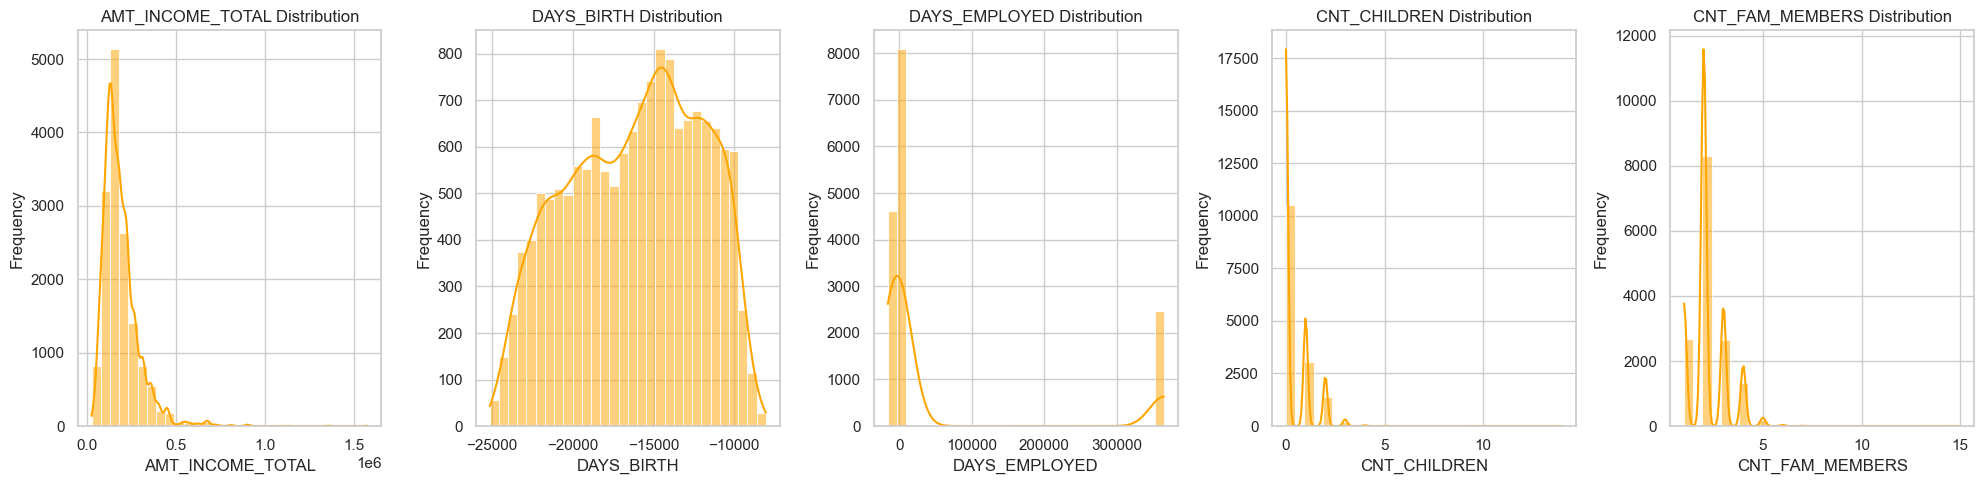

Looking on the DAYS_EMPLOYED plot we can clearly see that there are some outliers
It is difficult for us to simply remove those outliers due to their high frequency
We will investigate layter the way we will use them on the data cleaning process


In [370]:

sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
axes = axes.flatten()

selected_attributes = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED','CNT_CHILDREN','CNT_FAM_MEMBERS']

for i, attribute in enumerate(selected_attributes):
    sns.histplot(df[attribute], kde=True, color='orange', bins=30, ax=axes[i])
    axes[i].set_title(f'{attribute} Distribution')
    axes[i].set_xlabel(attribute)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print('Looking on the DAYS_EMPLOYED plot we can clearly see that there are some outliers')
print('It is difficult for us to simply remove those outliers due to their high frequency')
print('We will investigate layter the way we will use them on the data cleaning process')

In [371]:
print("Let's check each case now based on the target classes.")
classes = df['target'].unique()
marker = {0:'blue',1:'orange'}
selected_attributes = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED','CNT_CHILDREN','CNT_FAM_MEMBERS']
selected_attributes_classes = ['AMT_INCOME_TOTAL Normal','AMT_INCOME_TOTAL Default', 'DAYS_BIRTH Normal','DAYS_BIRTH Default', 'DAYS_EMPLOYED Normal','DAYS_EMPLOYED Default','CNT_CHILDREN Normal','CNT_CHILDREN Default','CNT_FAM_MEMBERS Normal','CNT_FAM_MEMBERS Default']
rows = len(selected_attributes) // 2 + len(selected_attributes) % 2  # Calculate the number of rows needed
fig = make_subplots(rows=rows*2-1, cols=2, subplot_titles=selected_attributes_classes, shared_yaxes=False, column_widths=[0.5, 0.5])
row = 1
for key, i in enumerate(selected_attributes):
    print(key,i)
    row = row  # Calculate the row for the current subplot  # Calculate the column for the current subplot
    subset = df[df['target'] == 0]
    fig.add_trace(go.Histogram(x=subset[i], nbinsx=80,name=str(0), opacity=0.7,marker_color= marker[0]), row=row, col=1)
    subset = df[df['target'] == 1]
    fig.add_trace(go.Histogram(x=subset[i], nbinsx=80,name=str(1), opacity=0.7,marker_color= marker[1]), row=row, col=2)
    row=row+1
fig.update_layout(title_text="Distribution Plots for Each Column", showlegend=False, height=rows*400, width=1200)
fig.show()

Let's check each case now based on the target classes.
0 AMT_INCOME_TOTAL
1 DAYS_BIRTH
2 DAYS_EMPLOYED
3 CNT_CHILDREN
4 CNT_FAM_MEMBERS


- Whisker plot

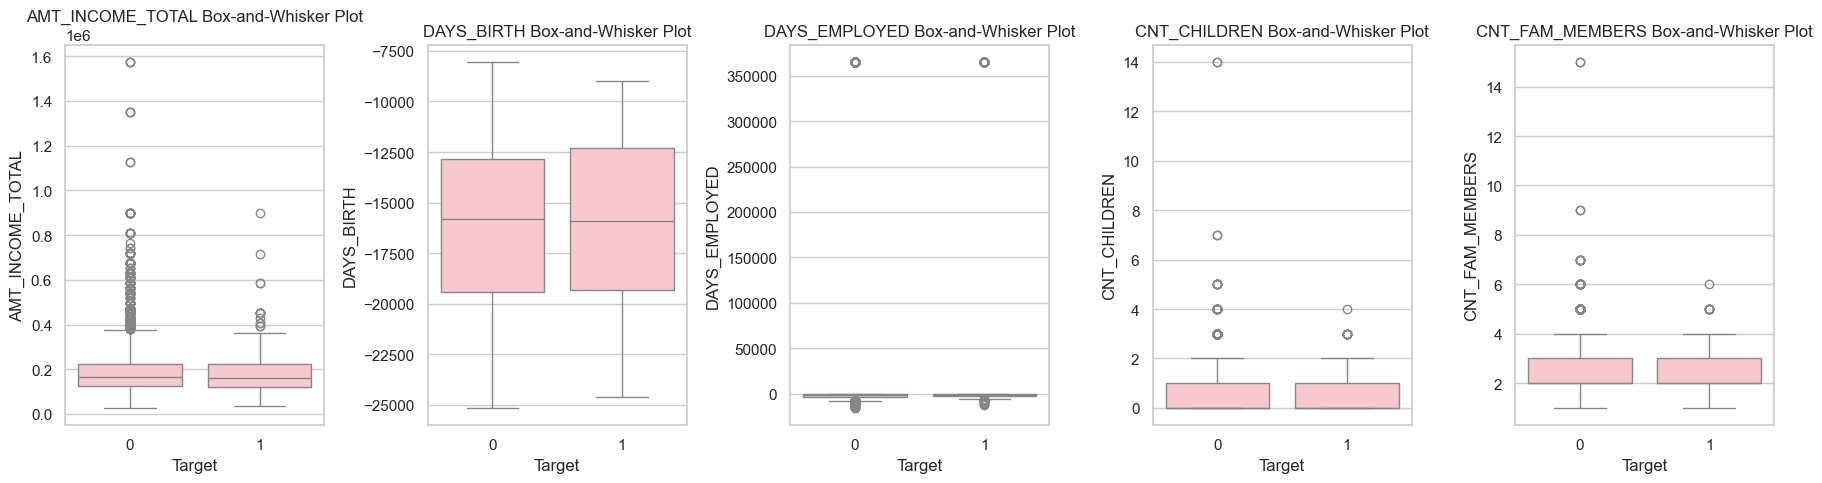

In [372]:

selected_numeric_features = df[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED','CNT_CHILDREN','CNT_FAM_MEMBERS', 'target']]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 5))
axes = axes.flatten()

# Iterate through selected numeric features
for i, feature in enumerate(selected_numeric_features.columns[:-1]):
    sns.boxplot(x='target', y=feature, data=selected_numeric_features, ax=axes[i], color='pink')
    axes[i].set_title(f'{feature} Box-and-Whisker Plot')
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [373]:
selected_numeric_features = df[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED','CNT_CHILDREN','CNT_FAM_MEMBERS']]
selected_numeric_features.describe()

AMT_INCOME_TOTAL    DAYS_BIRTH  DAYS_EMPLOYED  CNT_CHILDREN  \
count      1.516600e+04  15166.000000   15166.000000  15166.000000   
mean       1.892706e+05 -16164.022682   56989.955756      0.432481   
std        1.019689e+05   4049.207984  135821.976193      0.749122   
min        2.700000e+04 -25152.000000  -15661.000000      0.000000   
25%        1.260000e+05 -19441.000000   -3335.000000      0.000000   
50%        1.665000e+05 -15812.000000   -1748.000000      0.000000   
75%        2.250000e+05 -12801.000000    -451.000000      1.000000   
max        1.575000e+06  -8041.000000  365243.000000     14.000000   

       CNT_FAM_MEMBERS  
count     15166.000000  
mean          2.219768  
std           0.908491  
min           1.000000  
25%           2.000000  
50%           2.000000  
75%           3.000000  
max          15.000000

##### Categorical features

- Bar plots

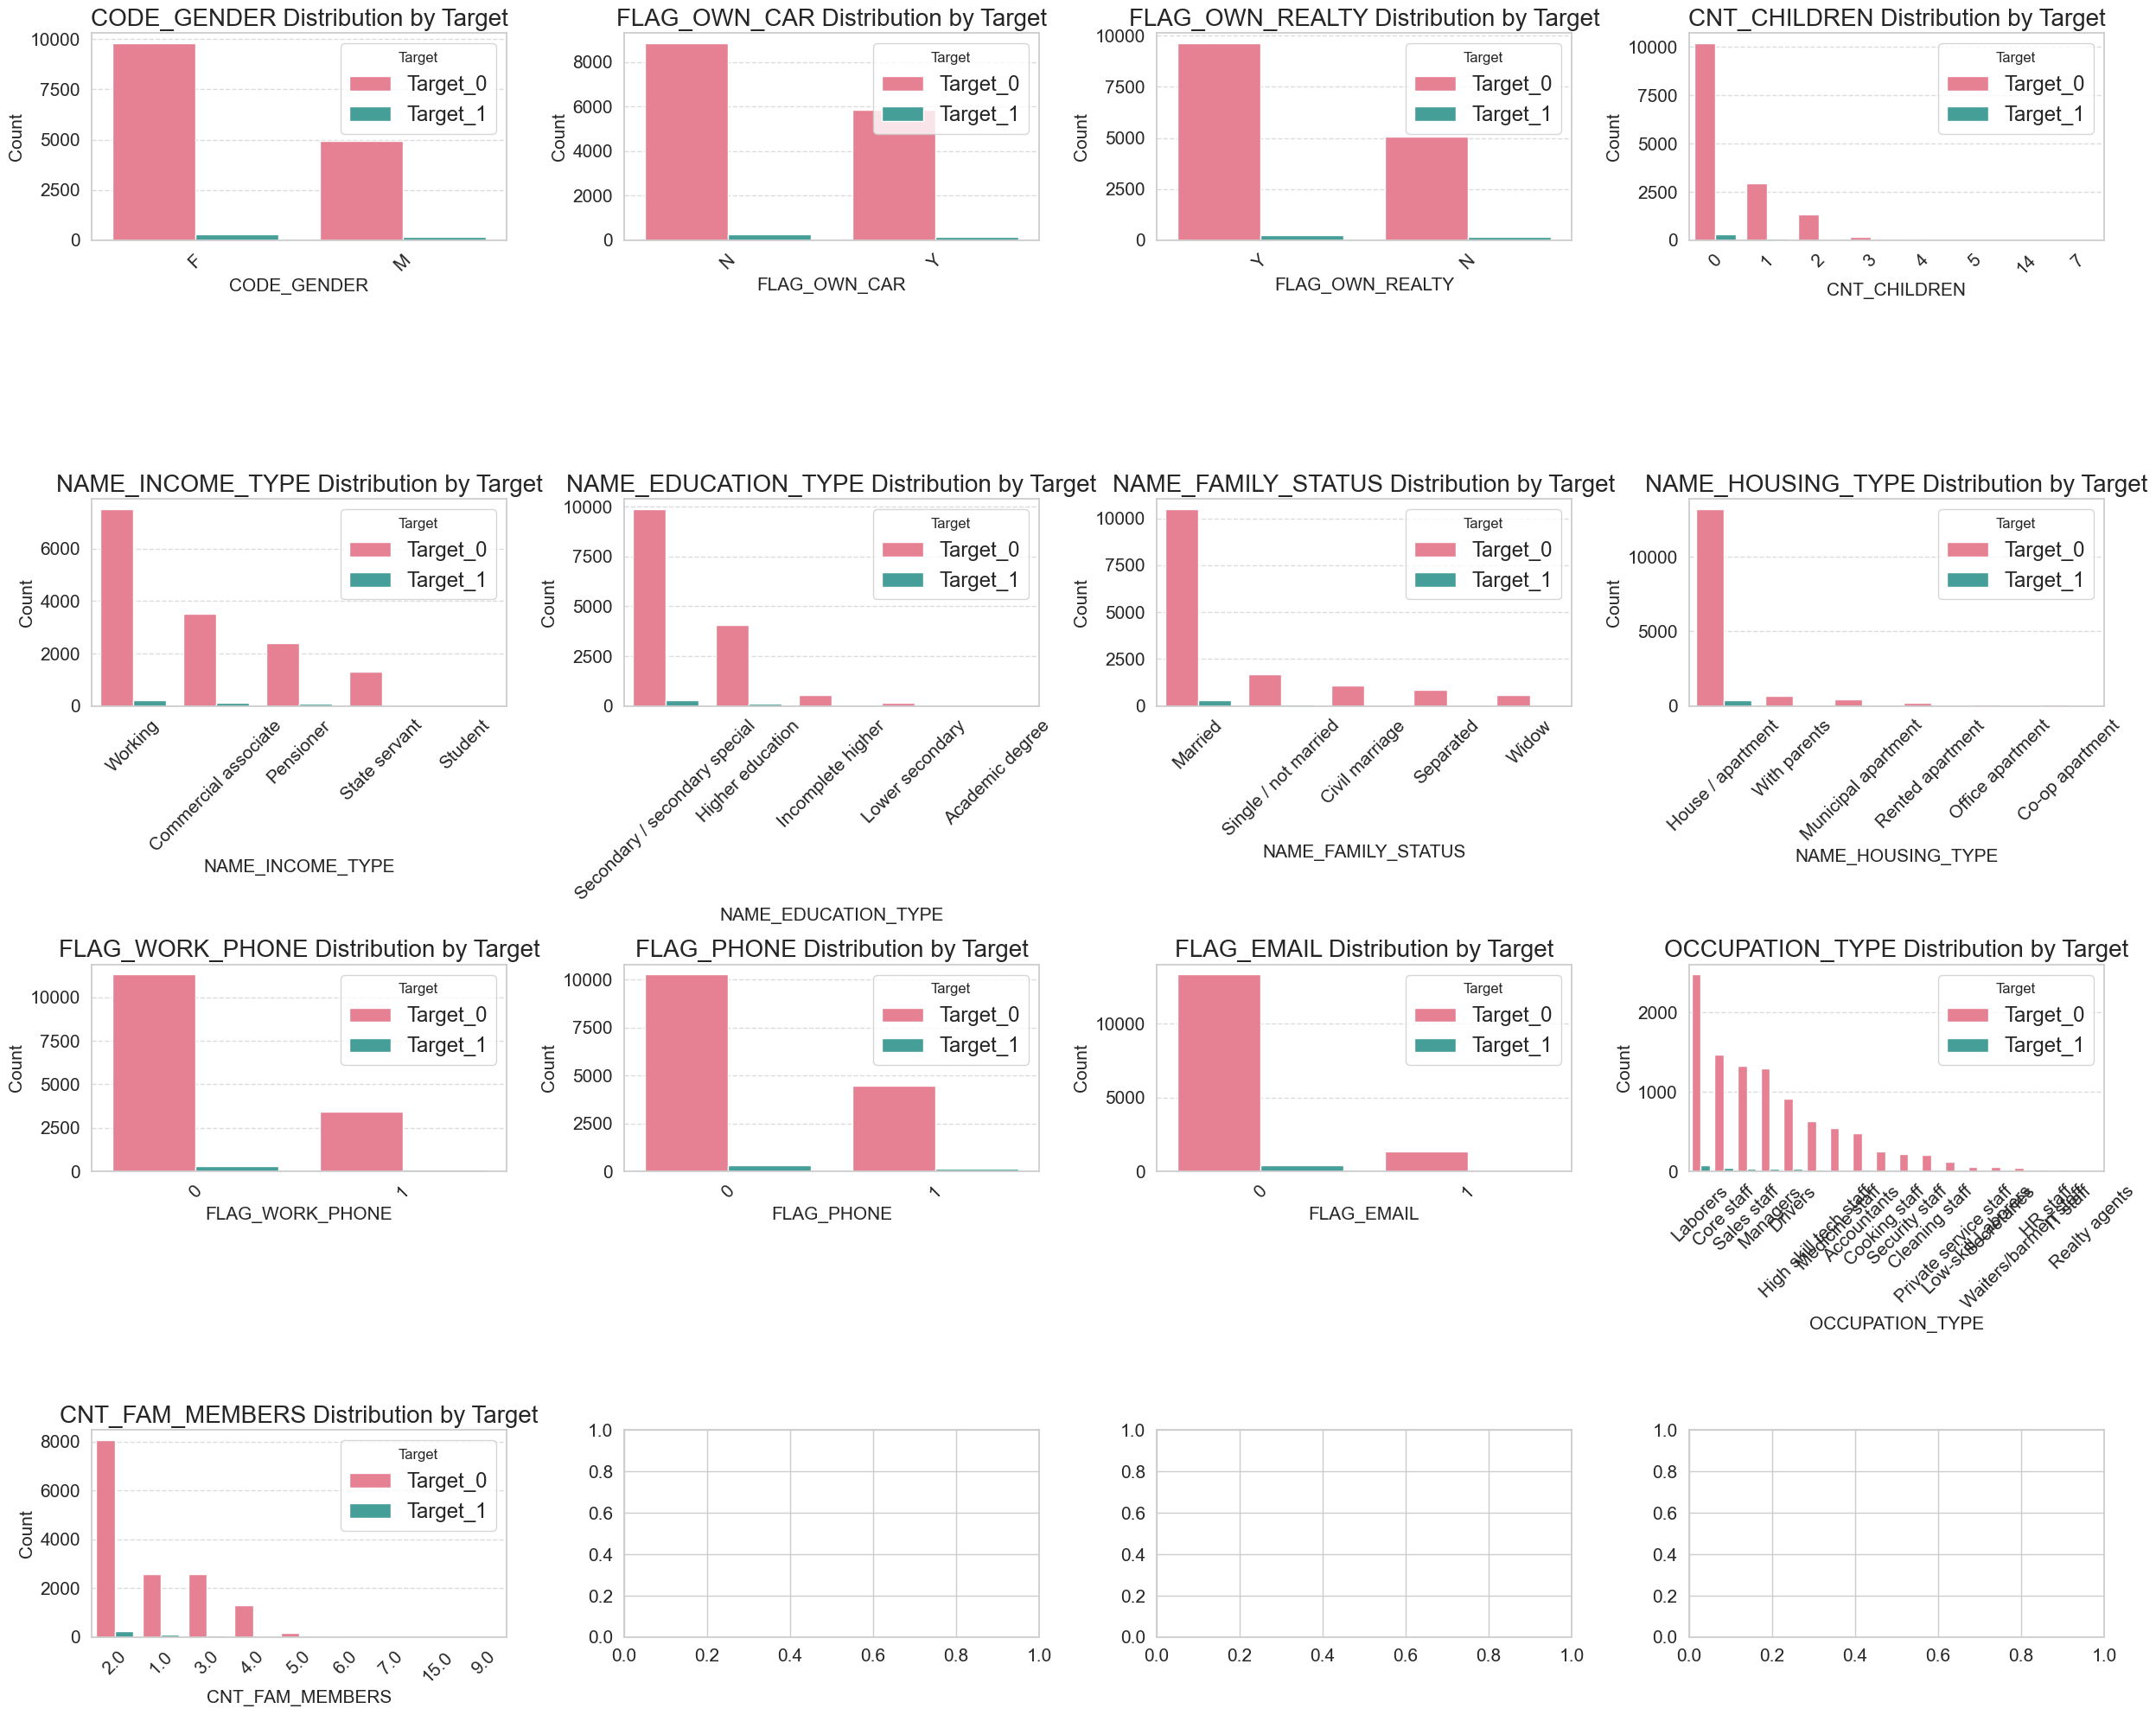

In [374]:
from pylab import rcParams
rcParams['figure.figsize'] = (25, 20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
custom_palette = sns.color_palette("husl", 2)  

attributes = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
              'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
              'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
              'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

# Create a grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 20))
axes = axes.flatten()

# Iterate through attributes and create subplots
for i, attribute in enumerate(attributes):
    p = sns.countplot(x=attribute, hue='target', data=df, palette=custom_palette, ax=axes[i], order=df[attribute].value_counts().index)
    p.legend(title='Target', fontsize='x-large', labels=['Target_0', 'Target_1'])
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].set_xlabel(attribute, fontsize=15)
    axes[i].set_ylabel("Count", fontsize=15)
    axes[i].set_title(f"{attribute} Distribution by Target", fontsize=20)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


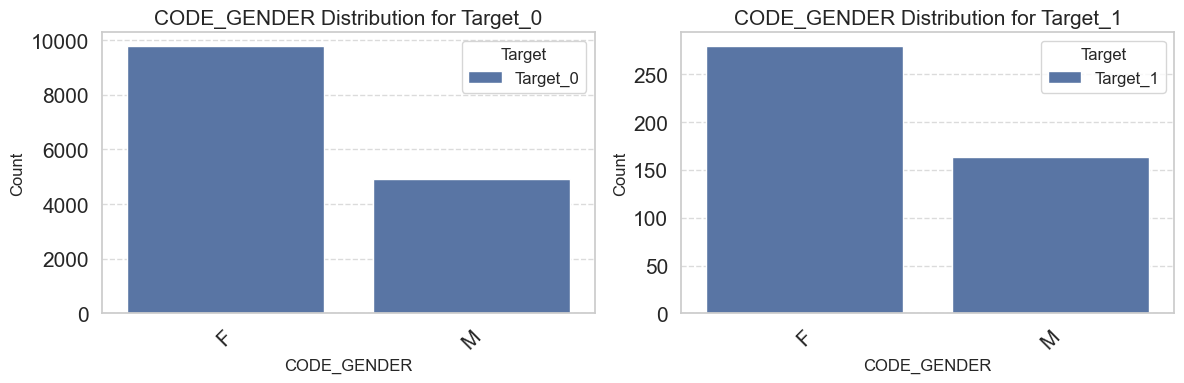

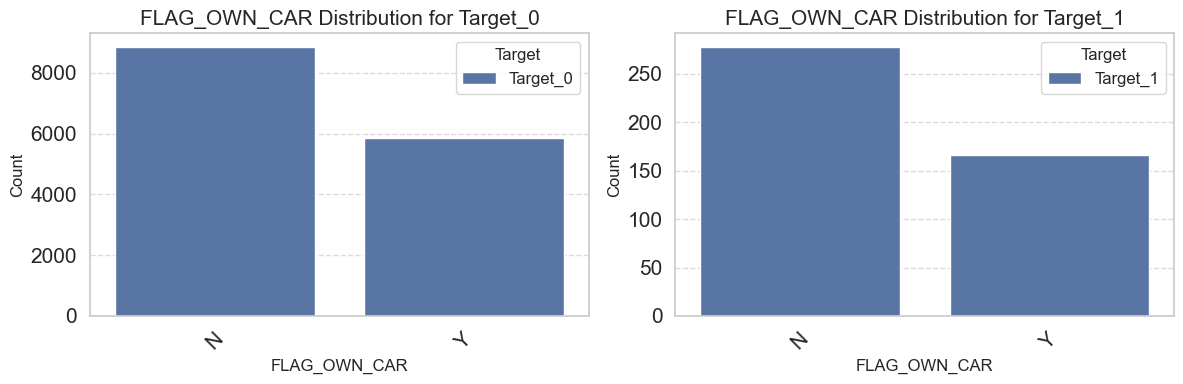

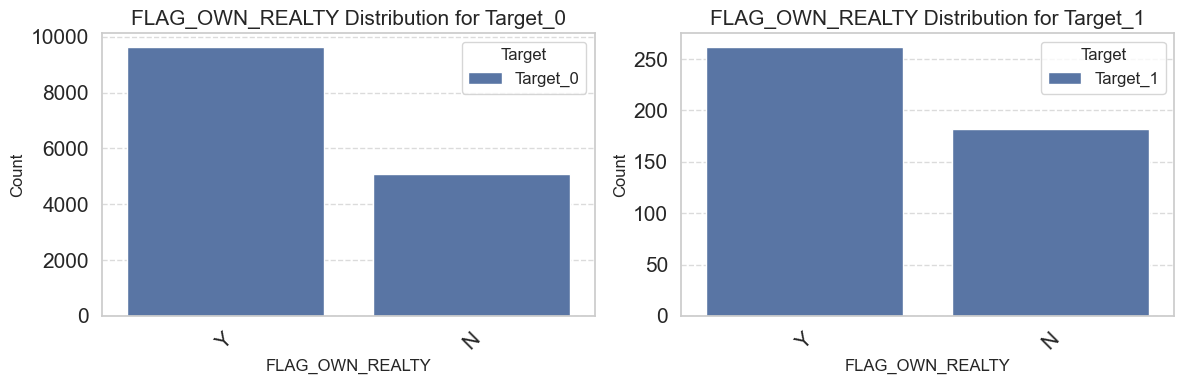

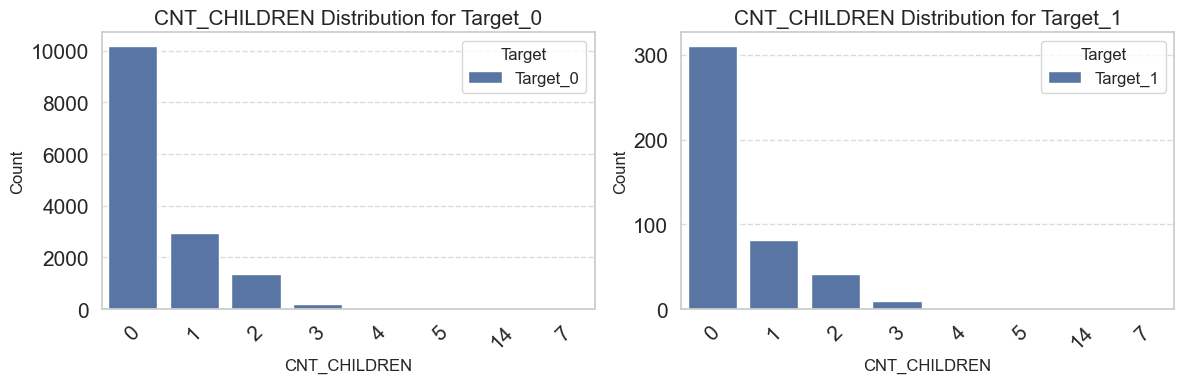

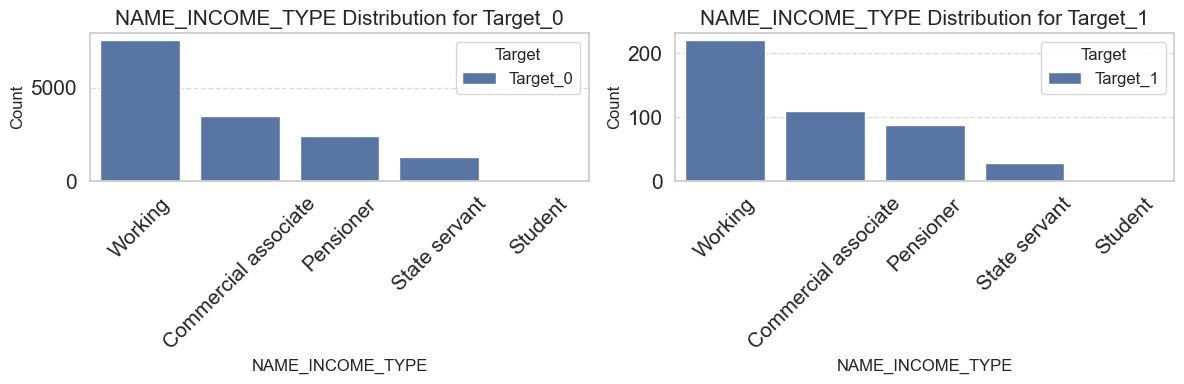

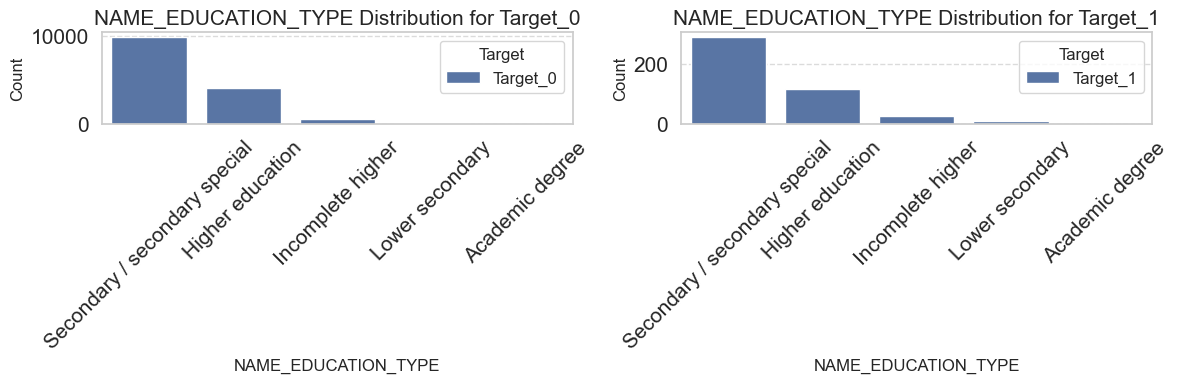

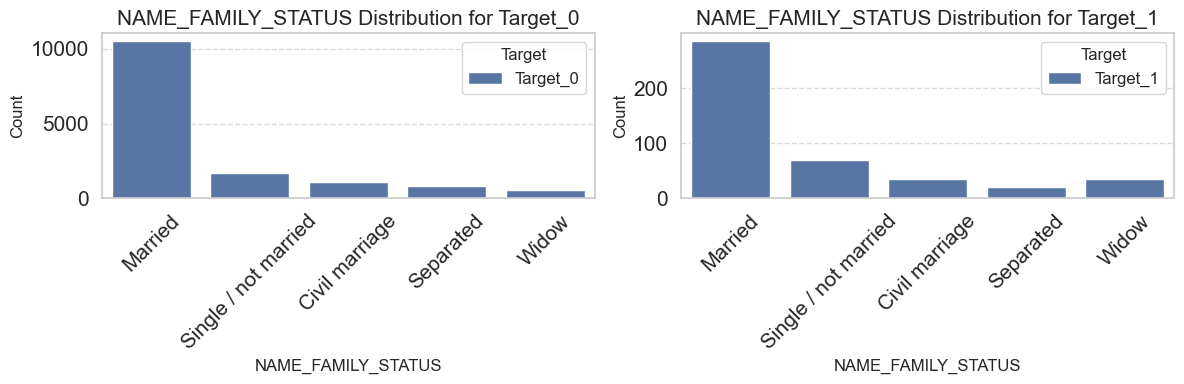

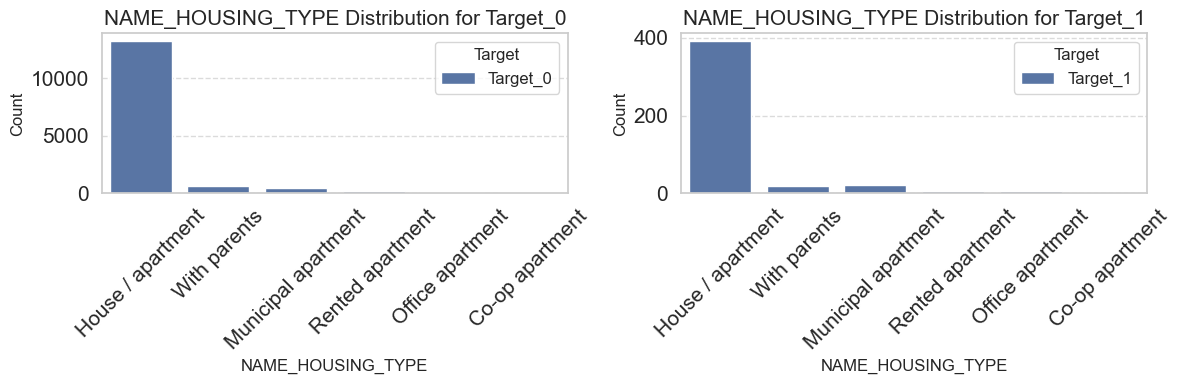

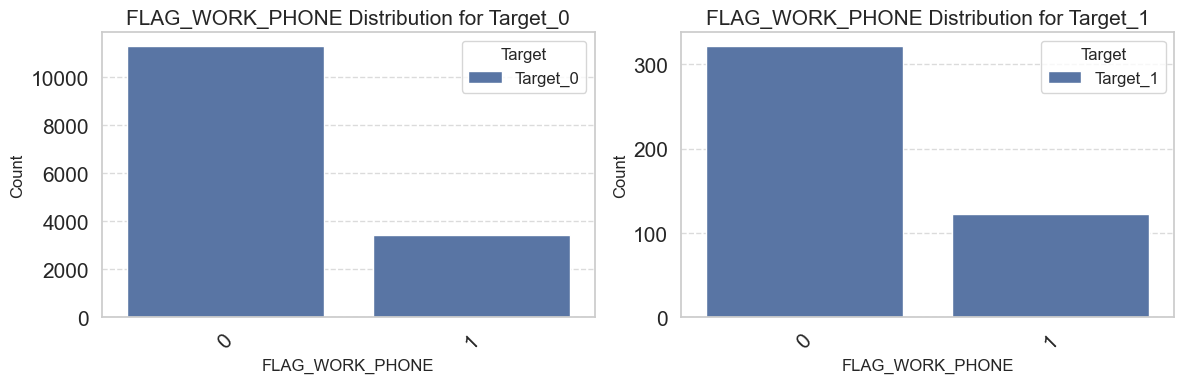

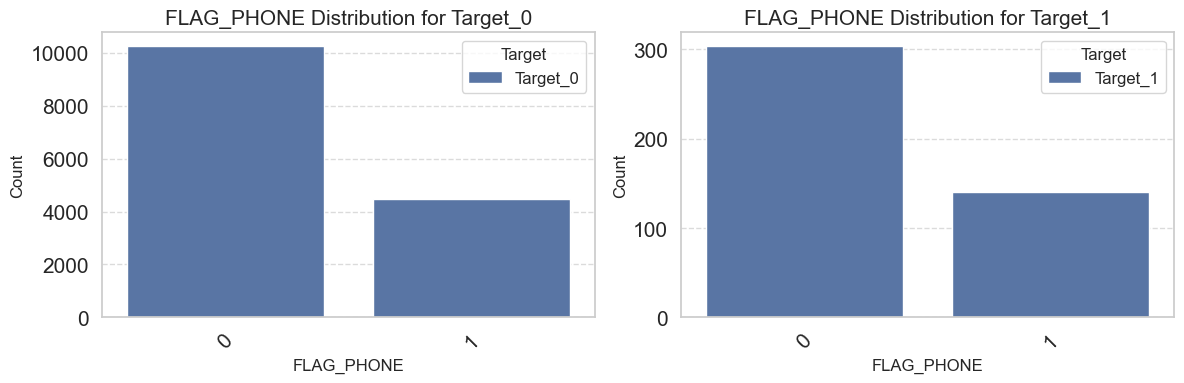

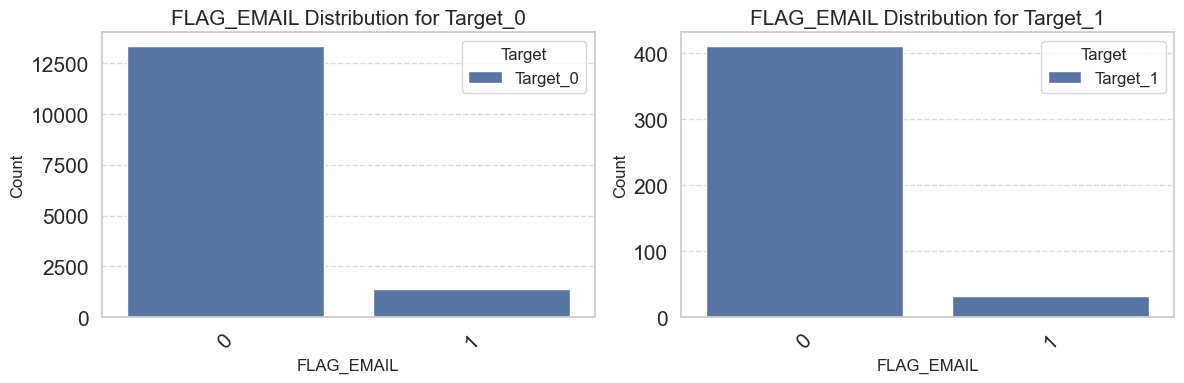

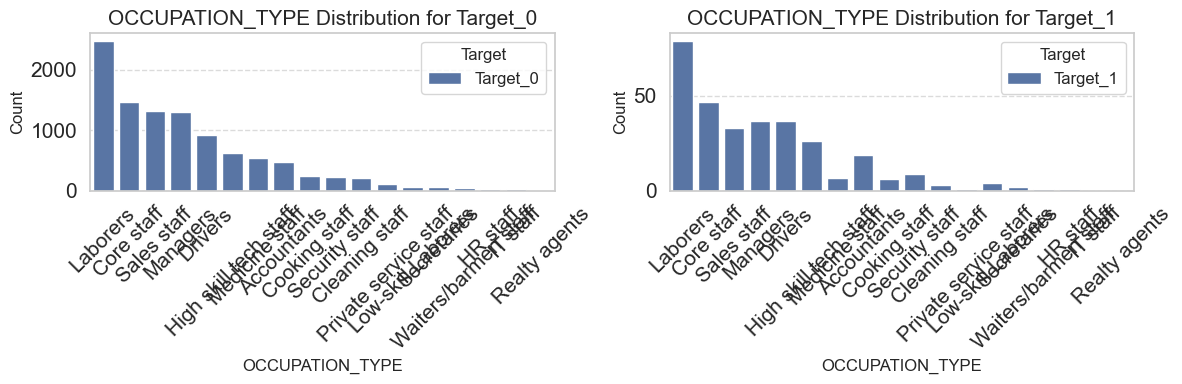

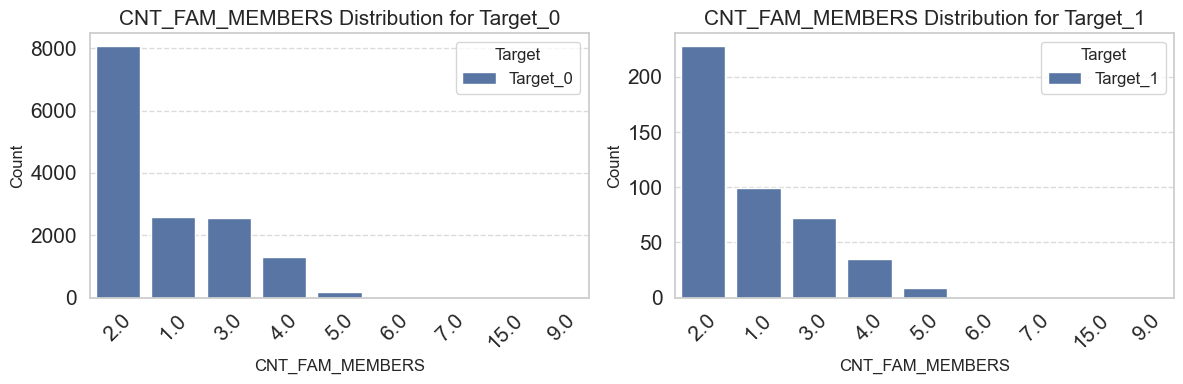

<Figure size 2500x2000 with 0 Axes>

In [375]:
rcParams['figure.figsize'] = (25, 20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
# custom_palette = sns.color_palette("husl", 2)  

attributes = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
              'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
              'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
              'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

# Create a grid of subplots
for attribute in attributes:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    
    for i, target_value in enumerate(df['target'].unique()):
        subset = df[df['target'] == target_value]
        p = sns.countplot(x=attribute, data=subset,  ax=axes[i], order=df[attribute].value_counts().index)
        p.set_title(f"{attribute} Distribution for Target_{target_value}", fontsize=15)
        p.grid(axis='y', linestyle='--', alpha=0.7)
        p.set_xlabel(attribute, fontsize=12)
        p.set_ylabel("Count", fontsize=12)
        p.legend(title='Target', fontsize='medium', labels=[f'Target_{target_value}'])
        p.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

plt.tight_layout()
plt.show()


#### Data Cleaning

In [376]:
print("Firstly, we need to drop unnecessary columns.")
print("Shape of dataframe before:{}".format(df.shape))
df.drop(['ID','FLAG_MOBIL'], axis=1, inplace=True)
print("Shape of dataframe after:{}".format(df.shape))

Firstly, we need to drop unnecessary columns.
Shape of dataframe before:(15166, 19)
Shape of dataframe after:(15166, 17)


In [377]:
print("Drop duplicate values:")
df.drop_duplicates(keep='first',inplace=True)
print("Shape of dataframe now:{}".format(df.shape))

Drop duplicate values:
Shape of dataframe now:(6163, 17)


In [378]:
print("Fill missing values in column OCCUPATION_TYPE with \"Other\".")
df['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)
df['OCCUPATION_TYPE'].head(7)

Fill missing values in column OCCUPATION_TYPE with "Other".


0    Security staff
1       Sales staff
3       Accountants
4       Accountants
6          Laborers
8             Other
9          Managers
Name: OCCUPATION_TYPE, dtype: object

In [379]:
print("Final number of records in the dataset: {}".format(df.shape[0]))
print('New class distribution: ')
print(df['target'].value_counts())
new_df = df['target'].value_counts().rename_axis('target').reset_index(name='counts')
fig = px.bar(new_df, x="target", y="counts", color="counts", title="Class distribution").update_layout(
     yaxis_title="Risk",width = 1200
)
fig.show()

Final number of records in the dataset: 6163
New class distribution: 
target
0    5837
1     326
Name: count, dtype: int64


As, it is observed, the data are imbalanced, therefore after further cleaning, oversampling methods need to be executed like SMOTE etc. in order to have a representative distribution of each class.

##### Encoding categorical features

In this part we will encode some categorical features in order to have more effective dataset. 

In [380]:
# Encode binary features
print("At first, we will encode the binary features CODE_GENDER, FLAG_OWN_CAR and FLAG_OWN_REALTY.") 
print("In the attribute CODE_GENDER we will replace female 'F' to value 0 and male 'M' to value 1.")
df["CODE_GENDER"] =  df["CODE_GENDER"].replace(['F','M'],[0,1])
print("In the attribute FLAG_OWN_CAR we will replace yes 'Y' and no 'N' to 1 and 0 respectively.")
df["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].replace(["Y","N"],[1,0])
print("In the attribute FLAG_OWN_REALTY we will replace as above yes 'Y' and no 'N' to 1 and 0 respectively.")
df["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].replace(["Y","N"],[1,0])

At first, we will encode the binary features CODE_GENDER, FLAG_OWN_CAR and FLAG_OWN_REALTY.
In the attribute CODE_GENDER we will replace female 'F' to value 0 and male 'M' to value 1.
In the attribute FLAG_OWN_CAR we will replace yes 'Y' and no 'N' to 1 and 0 respectively.
In the attribute FLAG_OWN_REALTY we will replace as above yes 'Y' and no 'N' to 1 and 0 respectively.


In [381]:
#encoding ordinal feature
print("In the attribute NAME_EDUCATION_TYPE there are five unique values which are :")
x = df['NAME_EDUCATION_TYPE'].unique()
print("Because this column has a hierarchy, we are going to implement ordinal encoding in order to preserve the ordinal nature of our feature.")
print("Label encoding should not be used with linear models where magnitude of features plays an important role.\nSince tree based algorithms do not need feature normalization, label encoding can be easily used with these models such as :\n\nDecision trees, Random forest, XGBoost, LightGBM")
print("This is important to take into account when training our models.")
print(x)
print("In order to have an effective dataset we will replace the attributes  Lower secondary, Secondary / secondary special, Incomplete higher,")
print(" Higher education, Academic degree to 0,1,2,3,4, respectively.")
df["NAME_EDUCATION_TYPE"] = df["NAME_EDUCATION_TYPE"].replace(["Lower secondary","Secondary / secondary special", "Incomplete higher", "Higher education", "Academic degree"],[0,1,2,3,4])

In the attribute NAME_EDUCATION_TYPE there are five unique values which are :
Because this column has a hierarchy, we are going to implement ordinal encoding in order to preserve the ordinal nature of our feature.
Label encoding should not be used with linear models where magnitude of features plays an important role.
Since tree based algorithms do not need feature normalization, label encoding can be easily used with these models such as :

Decision trees, Random forest, XGBoost, LightGBM
This is important to take into account when training our models.
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
In order to have an effective dataset we will replace the attributes  Lower secondary, Secondary / secondary special, Incomplete higher,
 Higher education, Academic degree to 0,1,2,3,4, respectively.


In [382]:
def one_hot_encod(data,column):

    # Converting type of columns to category 
    data[column] = data[column].astype('category')

    # Assigning numerical values 
    data[column] = data[column].cat.codes 
    # print(data[column])

    # Create an instance of One-hot-encoder 
    enc = OneHotEncoder() 
    
    # Passing encoded columns 
    enc_data = pd.DataFrame(enc.fit_transform( 
        data[[column]]).toarray()) 
    
    # Merge with main 
    for j in enc_data.columns:
        # print(j)
        data[column + str(j)] = enc_data[j]
        # print(enc_data[j])
    # return data

In [383]:
df.reset_index(drop=True,inplace=True)
#encoding categorical features
print("In this case, because our categorical variables NAME_FAMILY_STATUS, NAME_HOUSING_TYPE and  OCCUPATION_TYPE have equal order, we are going to implement One-hot encoding.")
print("In One-hot encoding our number of features will increase, which is not good for any tree based algorithm like Decision-trees, Random Forest etc. ")
print("But still, we can check later the importance of categorical features by using feature_importances_ hyperparameter in sklearn. If the feature is having low importance we can drop it off.")
print("Another way to fix this high- cardinality issue, is to group some feature's categories, for example for the column Occupation Type, group cases like Cleaning staff and Cooking staff in one category called Labor_workers.\n")
print("\nIn the attribute NAME_INCOME_TYPE there are {} unique values which are :\n{}".format(df['NAME_INCOME_TYPE'].nunique(),df['NAME_INCOME_TYPE'].unique()))
one_hot_encod(df,'NAME_INCOME_TYPE')
 
print("\nIn the attribute NAME_FAMILY_STATUS there are {} unique values which are :\n{}".format(df['NAME_FAMILY_STATUS'].nunique(),df['NAME_FAMILY_STATUS'].unique()))
one_hot_encod(df,'NAME_FAMILY_STATUS')

print("\nIn the attribute NAME_HOUSING_TYPE there are {} unique values which are :\n{}".format(df['NAME_HOUSING_TYPE'].nunique(),df['NAME_HOUSING_TYPE'].unique()))
one_hot_encod(df,'NAME_HOUSING_TYPE')

print("\nIn the attribute OCCUPATION_TYPE there are {} unique values which are :\n{}".format(df['OCCUPATION_TYPE'].nunique(),df['OCCUPATION_TYPE'].unique()))
print("Here, due to the large number of categories, we choose to group some of them.")
df.loc[(df['OCCUPATION_TYPE']=='Cleaning staff') | (df['OCCUPATION_TYPE']=='Cooking staff') | (df['OCCUPATION_TYPE']=='Drivers') | (df['OCCUPATION_TYPE']=='Laborers') | (df['OCCUPATION_TYPE']=='Low-skill Laborers') | (df['OCCUPATION_TYPE']=='Security staff') | (df['OCCUPATION_TYPE']=='Waiters/barmen staff'),'OCCUPATION_TYPE']='Labor_workers'
df.loc[(df['OCCUPATION_TYPE']=='Accountants') | (df['OCCUPATION_TYPE']=='Core staff') | (df['OCCUPATION_TYPE']=='HR staff') | (df['OCCUPATION_TYPE']=='Medicine staff') | (df['OCCUPATION_TYPE']=='Private service staff') | (df['OCCUPATION_TYPE']=='Realty agents') | (df['OCCUPATION_TYPE']=='Sales staff') | (df['OCCUPATION_TYPE']=='Secretaries'),'OCCUPATION_TYPE']='Office_workers'
df.loc[(df['OCCUPATION_TYPE']=='Managers') | (df['OCCUPATION_TYPE']=='High skill tech staff') | (df['OCCUPATION_TYPE']=='IT staff'),'OCCUPATION_TYPE']='Teck_workers'
one_hot_encod(df,'OCCUPATION_TYPE')


In this case, because our categorical variables NAME_FAMILY_STATUS, NAME_HOUSING_TYPE and  OCCUPATION_TYPE have equal order, we are going to implement One-hot encoding.
In One-hot encoding our number of features will increase, which is not good for any tree based algorithm like Decision-trees, Random Forest etc. 
But still, we can check later the importance of categorical features by using feature_importances_ hyperparameter in sklearn. If the feature is having low importance we can drop it off.
Another way to fix this high- cardinality issue, is to group some feature's categories, for example for the column Occupation Type, group cases like Cleaning staff and Cooking staff in one category called Labor_workers.


In the attribute NAME_INCOME_TYPE there are 5 unique values which are :
['Working' 'Commercial associate' 'State servant' 'Pensioner' 'Student']

In the attribute NAME_FAMILY_STATUS there are 5 unique values which are :
['Married' 'Single / not married' 'Civil marriage' 'Widow

For now we are going to keep the initial columns in order to do some more analysis, but before training we intend to drop them

##### Continuous features


In [384]:
print("For the case of CNT_FAM_MEMBERS and CNT_CHILDREN, we observe from the boxplots above, some outliers.\nIn order to deal with those edge cases and have a concistency across our dataset, we choose to group these columns into buckets by taking into account the boxplot results in each case.")
print("After organizing the results into buckets, we perform label encoding since they have been transformed into ordinal features.")
# CNT_CHILDREN
print("For column CNT_CHILDREN before: {}\n".format(df['CNT_CHILDREN'].value_counts()))
df.loc[df['CNT_CHILDREN'] >= 2,'CNT_CHILDREN']='2More'
print("For column CNT_CHILDREN after: {}\n".format(df['CNT_CHILDREN'].value_counts()))
# Converting type of columns to category 
df['CNT_CHILDREN'] = df['CNT_CHILDREN'].astype('category')
# Assigning numerical values 
df['CNT_CHILDREN'] = df['CNT_CHILDREN'].cat.codes

For the case of CNT_FAM_MEMBERS and CNT_CHILDREN, we observe from the boxplots above, some outliers.
In order to deal with those edge cases and have a concistency across our dataset, we choose to group these columns into buckets by taking into account the boxplot results in each case.
After organizing the results into buckets, we perform label encoding since they have been transformed into ordinal features.
For column CNT_CHILDREN before: CNT_CHILDREN
0     4318
1     1191
2      549
3       87
4       12
5        4
14       1
7        1
Name: count, dtype: int64

For column CNT_CHILDREN after: CNT_CHILDREN
0        4318
1        1191
2More     654
Name: count, dtype: int64



In [385]:
print("For column CNT_FAM_MEMBERS before: {}\n".format(df['CNT_FAM_MEMBERS'].value_counts()))
df.loc[df['CNT_FAM_MEMBERS'] >= 4,'CNT_FAM_MEMBERS']='4More'
print("For column CNT_FAM_MEMBERS after: {}\n".format(df['CNT_FAM_MEMBERS'].value_counts()))
# Converting type of columns to category 
df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].astype('category')
# Assigning numerical values 
df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].cat.codes

For column CNT_FAM_MEMBERS before: CNT_FAM_MEMBERS
2.0     3340
1.0     1167
3.0     1038
4.0      516
5.0       85
6.0       12
7.0        3
15.0       1
9.0        1
Name: count, dtype: int64

For column CNT_FAM_MEMBERS after: CNT_FAM_MEMBERS
2.0      3340
1.0      1167
3.0      1038
4More     618
Name: count, dtype: int64



For feature DAYS_BIRTH, we choose to convert it from days to years and create age buckets which we later will convert to categories using again label encoding


<Axes: ylabel='Frequency'>

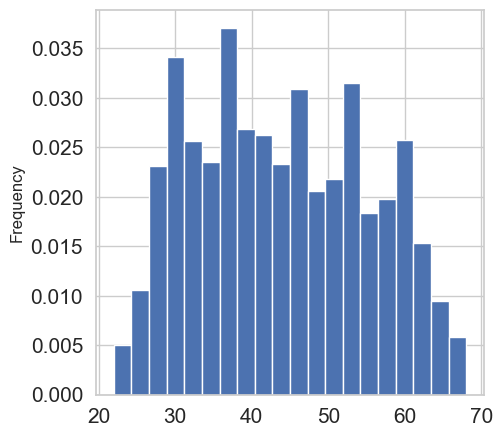

In [386]:
print("For feature DAYS_BIRTH, we choose to convert it from days to years and create age buckets which we later will convert to categories using again label encoding")
df['DAYS_BIRTH']=-(df['DAYS_BIRTH'])//365
df['DAYS_BIRTH'].plot(kind='hist',bins=20,density=True,figsize=(5,5))

In [387]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    df[col] = localdf[col]
    return df

We will 5 age buckets based on the data we have:


CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0            1             1                1             0          112500.0   
1            0             0                1             0          270000.0   
2            1             1                1             0          270000.0   

   NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                 4                    1                   1   
1                 0                    1                   3   
2                 4                    3                   1   

   NAME_HOUSING_TYPE DAYS_BIRTH  ...  NAME_HOUSING_TYPE0  NAME_HOUSING_TYPE1  \
0                  1          3  ...                 0.0                 1.0   
1                  1          3  ...                 0.0                 1.0   
2                  1          2  ...                 0.0                 1.0   

   NAME_HOUSING_TYPE2  NAME_HOUSING_TYPE3  NAME_HOUSING_TYPE4  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   

   NAME_HOUSING_TYPE5  OCCUPATION_TYPE0  OCCUPATION_TYPE1  OCCUPATION_TYPE2  \
0                 0.0               1.0               0.0               0.0   
1                 0.0               0.0               1.0               0.0   
2                 0.0               0.0               1.0               0.0   

   OCCUPATION_TYPE3  
0               0.0  
1               0.0  
2               0.0  

[3 rows x 37 columns]

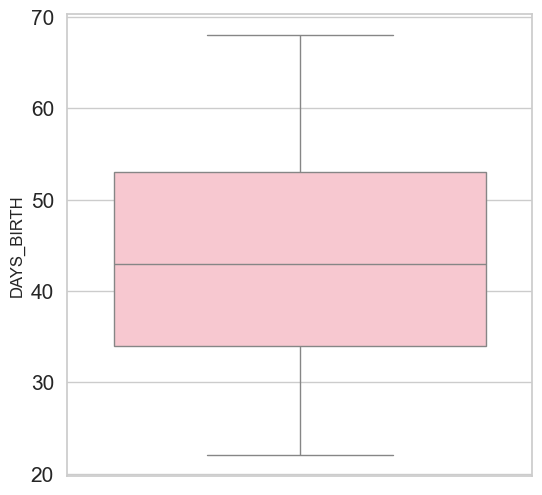

In [388]:
plt.figure(figsize=(6,6))
sns.boxplot( y='DAYS_BIRTH', data=df, color='pink')
print("We will 5 age buckets based on the data we have:")
get_category(df,'DAYS_BIRTH',5, ["lowest","low","medium","high","highest"])
df["DAYS_BIRTH"] = df["DAYS_BIRTH"].replace(["lowest","low","medium","high","highest"],[0,1,2,3,4])
df.head(3)


Finally, for DAYS_EMPLOYED, we observed from the above analysis that we have certain outliers, for example:


11      365243
16      365243
50      365243
52      365243
53      365243
         ...  
6137    365243
6138    365243
6145    365243
6146    365243
6154    365243
Name: DAYS_EMPLOYED, Length: 1076, dtype: int64

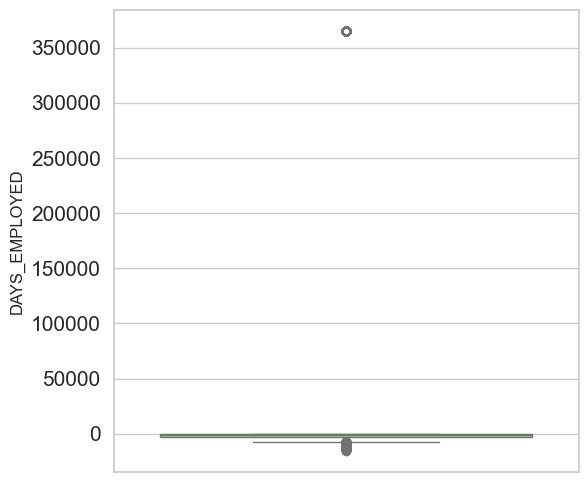

In [389]:
print("Finally, for DAYS_EMPLOYED, we observed from the above analysis that we have certain outliers, for example:")
plt.figure(figsize=(6,6))
sns.boxplot(y=df['DAYS_EMPLOYED'],  color='lightgreen')
df.loc[df['DAYS_EMPLOYED'] > 300000]['DAYS_EMPLOYED']

There are records with more than 365,243 value DAYS_EMPLOYED in that means that they have been unemployed for more than 1,000 years 
That is a data gathering/ storage issue.<br>We can either treat such cases with a clip (maximum realistic value from the data/ domain) or in this case we also can choose to simply transform this column into a flag (whether the client is employed or not).<br> Due to the large number of values that have this outlier, it wouldn't be wise to drop all those instances.

In [390]:
# Create unemployed indicator
df['FLAG_UNEMPLOYED']=0
df.loc[df['DAYS_EMPLOYED']>0,'FLAG_UNEMPLOYED']=1
# Create years employed feature
df['YEARS_EMPLOYED']=-df['DAYS_EMPLOYED']/365
# df.loc[df['YEARS_EMPLOYED']>0,'FLAG_UNEMPLOYED']=0
df[['FLAG_UNEMPLOYED','YEARS_EMPLOYED']].head(3)

FLAG_UNEMPLOYED  YEARS_EMPLOYED
0                0        3.106849
1                0        8.358904
2                0        2.106849

#### Final analysis and correlations

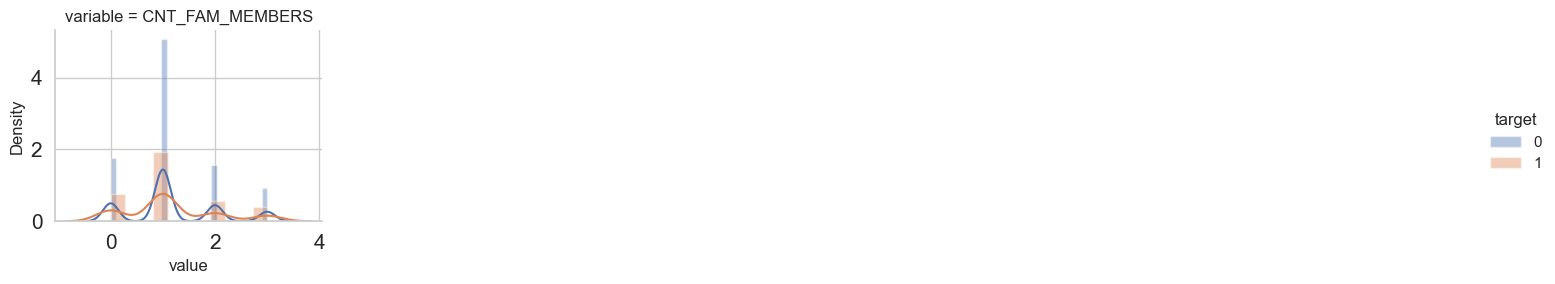

In [391]:
# Let's do a little EDA
cols = ['CNT_FAM_MEMBERS']
f = pd.melt( df, id_vars='target', value_vars=cols)
g = sns.FacetGrid( f, hue='target', col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

**Observations:**
- NonDefaults have a higher proportion of Females


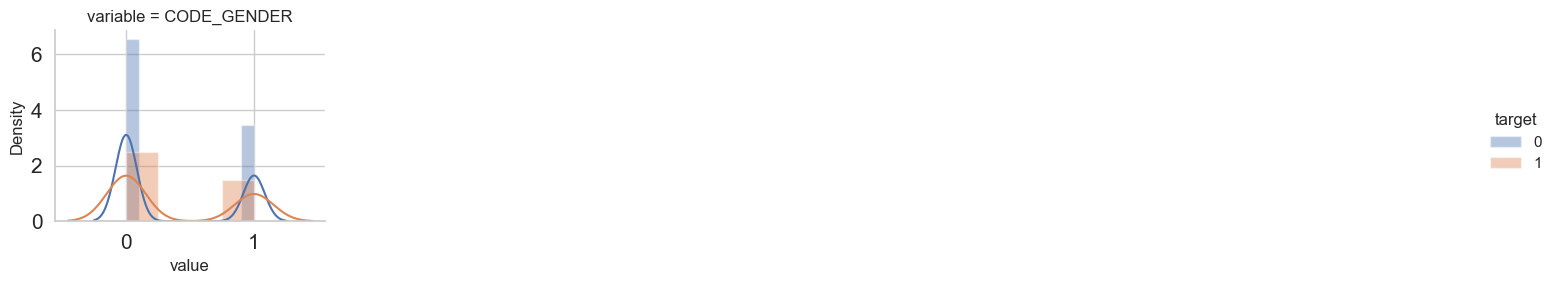

In [392]:
cols = ['CODE_GENDER']
f = pd.melt( df, id_vars='target', value_vars=cols)
g = sns.FacetGrid( f, hue='target', col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

- NonDefaults have a higher proportion of MoreEducated

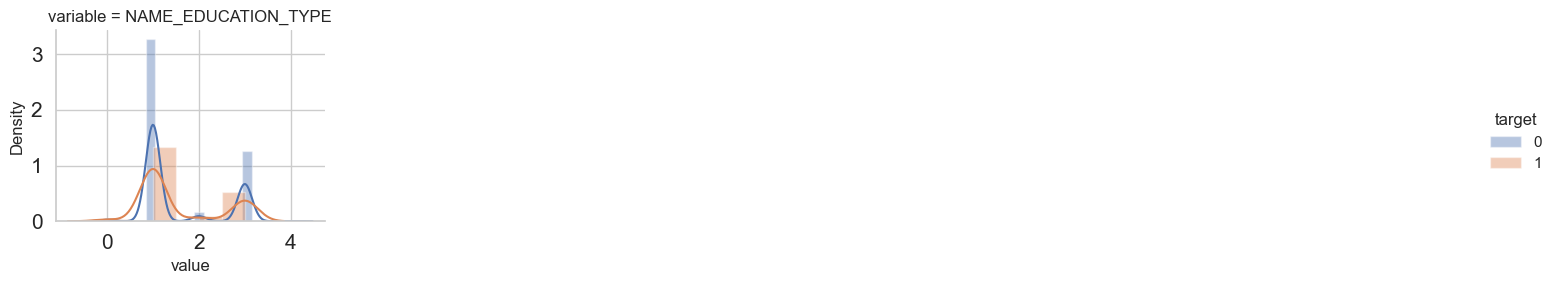

In [393]:
cols = ['NAME_EDUCATION_TYPE']
f = pd.melt( df, id_vars='target', value_vars=cols)
g = sns.FacetGrid( f, hue='target', col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

- NonDefaults have a higher proportion of people with 'low' age 

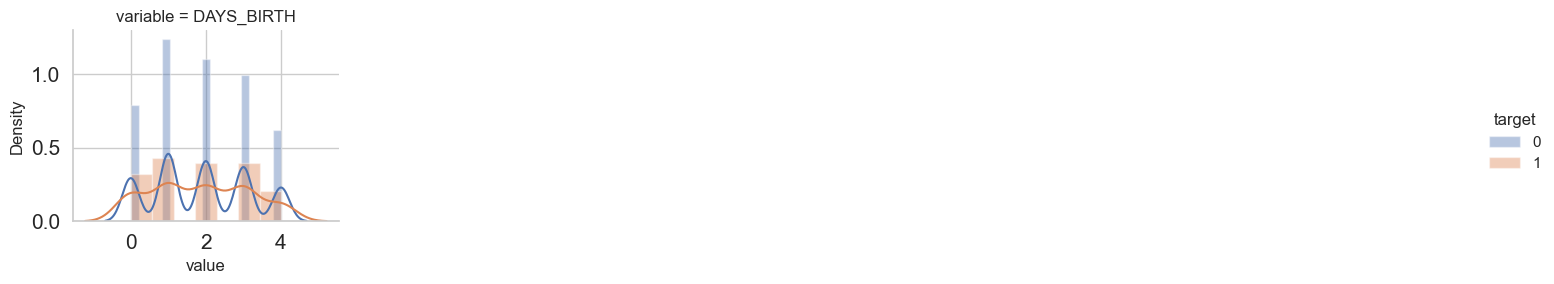

In [394]:
cols = ['DAYS_BIRTH']
f = pd.melt( df, id_vars='target', value_vars=cols)
g = sns.FacetGrid( f, hue='target', col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()


- NonDefaults have a higher proportion of Singles/Not Married

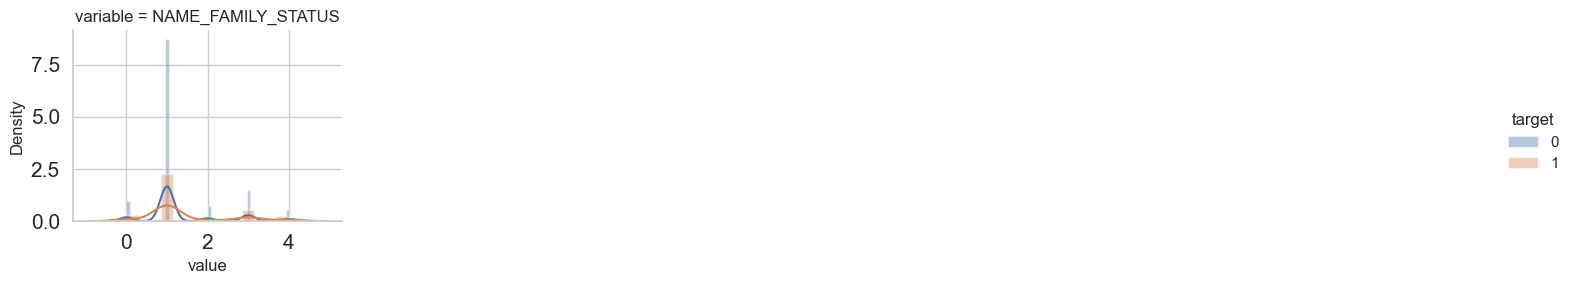

In [395]:
cols = ['NAME_FAMILY_STATUS']
f = pd.melt( df, id_vars='target', value_vars=cols)
g = sns.FacetGrid( f, hue='target', col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

#### Correlation Matrix and Heatmap

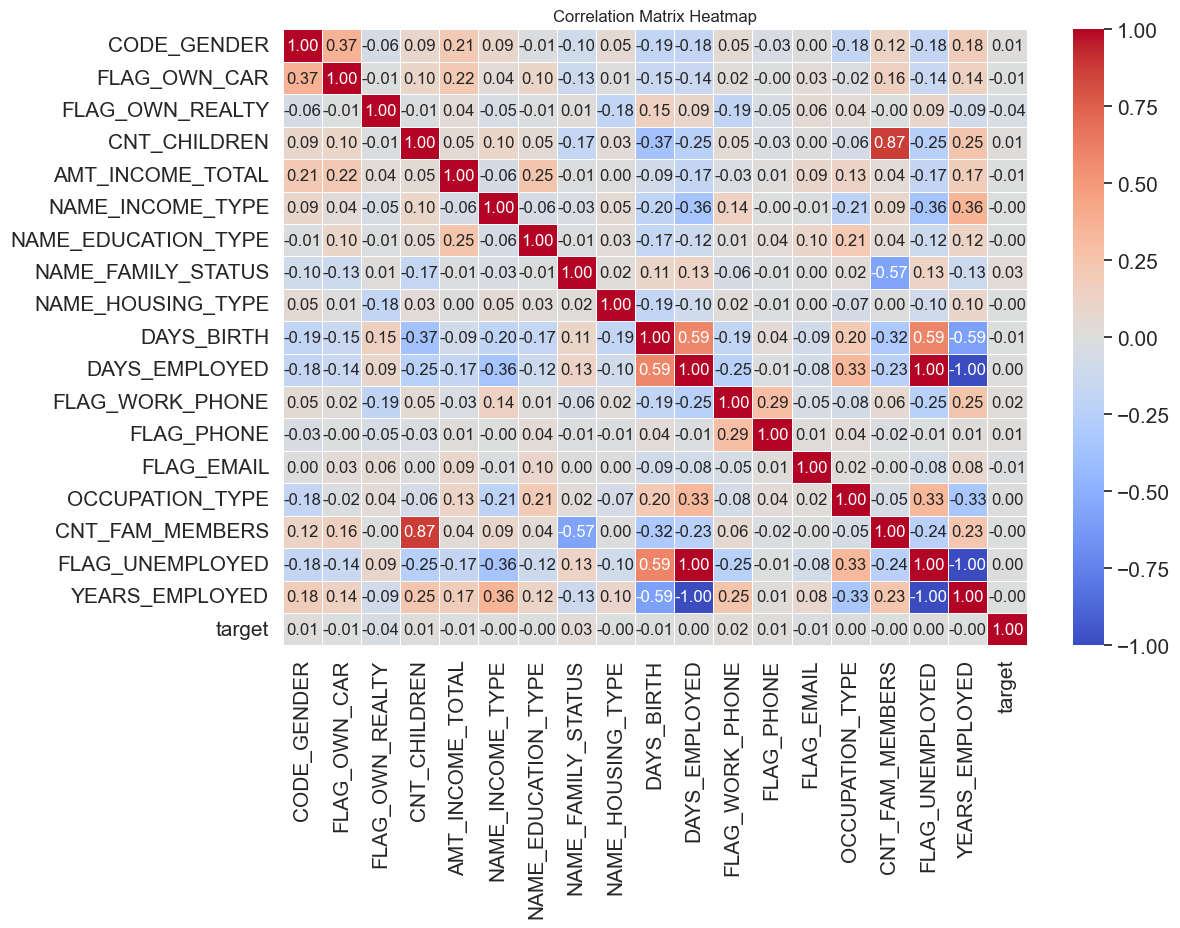

We can see hight positive correlation 0,89 between the number of family members and the number of children in the family
For thit reason in the next step we would like to delete one of them by checking the correlations of this attributes with the target.
As we can observe the most correlated feature (between the number of family members and number of children in the family) with the targe which is the feature of number of the children.
So, we will drop the feature of family members but we will do it later.
Also, from the correlation matrix we can see that YEARS_EMPLOYED, FLAG_EMPLOYED and DAYS_EMPLOYED are highly correlated as the values of the matrix between these three are 1 and -1.
This is expected since these attributes are based on the same column, making their values entirely correlated.


In [396]:
# Select numeric features for correlation analysis
selected_attributes = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'FLAG_UNEMPLOYED','YEARS_EMPLOYED' , 'target']

correlation_matrix = df[selected_attributes].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

print('We can see hight positive correlation 0,89 between the number of family members and the number of children in the family')
print('For thit reason in the next step we would like to delete one of them by checking the correlations of this attributes with the target.')
print('As we can observe the most correlated feature (between the number of family members and number of children in the family) with the targe which is the feature of number of the children.')
print('So, we will drop the feature of family members but we will do it later.')
print('Also, from the correlation matrix we can see that YEARS_EMPLOYED, FLAG_EMPLOYED and DAYS_EMPLOYED are highly correlated as the values of the matrix between these three are 1 and -1.')
print('This is expected since these attributes are based on the same column, making their values entirely correlated.')

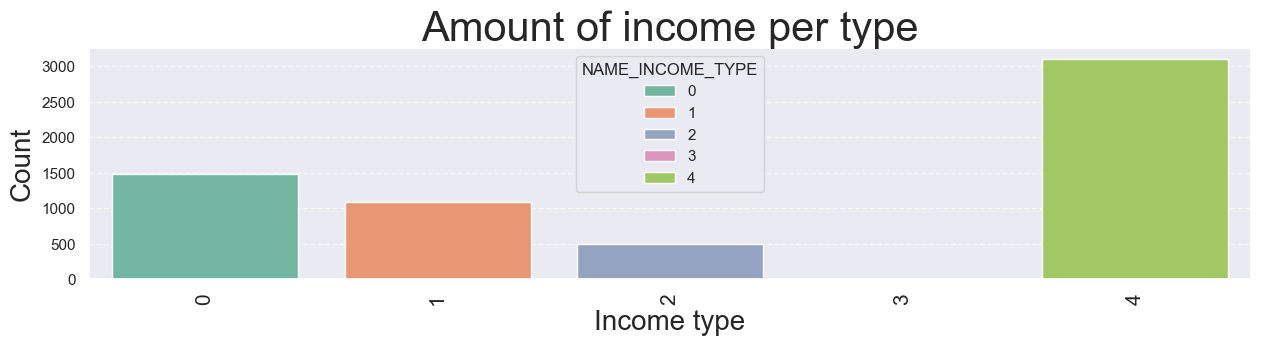

In [397]:

sns.set(rc={'figure.figsize': (15, 3)})
plt.xticks(fontsize=15, rotation='vertical')

custom_palette = sns.color_palette("Set2", len(df['NAME_INCOME_TYPE'].unique()))

p = sns.countplot(x='NAME_INCOME_TYPE', data=df, hue='NAME_INCOME_TYPE', palette=custom_palette)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel("Income type", fontsize=20)
plt.ylabel("Count", fontsize=20)
p.set_title("Amount of income per type", fontsize=30)

plt.show()

What if we check correlation now only with the target variable


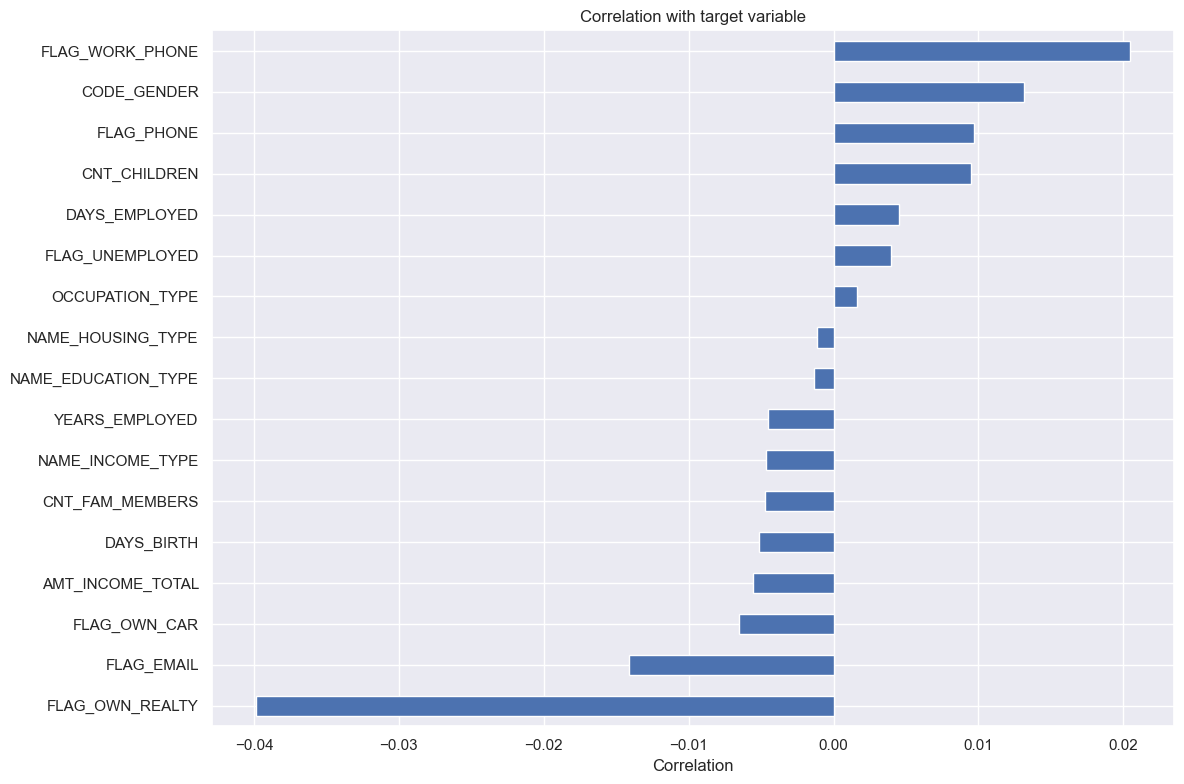

Previously we saw that DAYS_EMPLOYED, YEARS_EMPLOYED and FLAG_EMPLOYED that they are entirely correlated. We will keep one of them, the one which is the most correlated.


In [398]:
print("What if we check correlation now only with the target variable")
plt.figure(figsize=(12,8))
correlation_matrix = correlation_matrix.drop('target')
correlation_matrix['target'].sort_values(ascending=True)[:-1].plot(kind="barh")
plt.title("Correlation with target variable")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()

print('Previously we saw that DAYS_EMPLOYED, YEARS_EMPLOYED and FLAG_EMPLOYED that they are entirely correlated. We will keep one of them, the one which is the most correlated.')

#### Split into train and test

In [399]:
X = df[['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL','NAME_EDUCATION_TYPE','DAYS_BIRTH','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','CNT_FAM_MEMBERS','FLAG_UNEMPLOYED','YEARS_EMPLOYED','NAME_INCOME_TYPE0',
       'NAME_INCOME_TYPE1', 'NAME_INCOME_TYPE2', 'NAME_INCOME_TYPE3',
       'NAME_INCOME_TYPE4', 'NAME_FAMILY_STATUS0', 'NAME_FAMILY_STATUS1',
       'NAME_FAMILY_STATUS2', 'NAME_FAMILY_STATUS3', 'NAME_FAMILY_STATUS4',
       'NAME_HOUSING_TYPE0', 'NAME_HOUSING_TYPE1', 'NAME_HOUSING_TYPE2',
       'NAME_HOUSING_TYPE3', 'NAME_HOUSING_TYPE4', 'NAME_HOUSING_TYPE5',
       'OCCUPATION_TYPE0', 'OCCUPATION_TYPE1', 'OCCUPATION_TYPE2',
       'OCCUPATION_TYPE3']]
Y = df['target'].astype(int)

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)
# Create DataFrames for y_train and y_test
df_train = pd.DataFrame({'target': y_train, 'dataset': 'Train'})
df_test = pd.DataFrame({'target': y_test, 'dataset': 'Test'})
df_combined = pd.concat([df_train, df_test])

# Plot distributions using Plotly Express
fig = px.histogram(df_combined, x='target', color='dataset', barmode='group', category_orders={'target': [0, 1]},
                   labels={'target': 'Target', 'dataset': 'Dataset'},
                   title='Distribution of Target in Train and Test Sets')
fig.update_layout(width = 1000)
fig.show()


From now on, we are going to continue with the training data only!

#### Normalization of features
Normalizing our features before oversampling depends on the specific oversampling technique we are using and the nature of our data. <br>
For the case of SMOTE which generates synthetic samples in feature space, it's generally a good idea to normalize our features.<br> Normalization ensures that all features contribute equally to the creation of synthetic samples.

In [401]:
scaler =MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled[0]

array([0.        , 0.        , 1.        , 0.        , 0.11564626,
       0.25      , 0.75      , 0.        , 0.        , 0.        ,
       0.33333333, 0.        , 0.9728278 , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        ])

#### Feature selection

Tree-based feature selection using SelectFromModel for linear and tree-based cases. <br>
It is a meta-transformer for selecting features based on importance weights.

In [402]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression()))
])
clf.fit(X_scaled, y_train)
# Retrieve the selected features
selected_features_mask = clf.named_steps['feature_selection'].get_support()
selected_features_1 = [feature for feature, mask in zip(X.columns, selected_features_mask) if mask]
selected_features_1

['AMT_INCOME_TOTAL',
 'FLAG_UNEMPLOYED',
 'YEARS_EMPLOYED',
 'NAME_INCOME_TYPE0',
 'NAME_INCOME_TYPE1',
 'NAME_INCOME_TYPE2',
 'NAME_INCOME_TYPE4',
 'NAME_HOUSING_TYPE2',
 'NAME_HOUSING_TYPE5']

In [403]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(ExtraTreesClassifier()))
])
clf.fit(X_scaled, y_train)
# Retrieve the selected features
selected_features_mask = clf.named_steps['feature_selection'].get_support()
selected_features_2 = [feature for feature, mask in zip(X.columns, selected_features_mask) if mask]
selected_features_2

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_EDUCATION_TYPE',
 'DAYS_BIRTH',
 'FLAG_PHONE',
 'CNT_FAM_MEMBERS',
 'YEARS_EMPLOYED']

In [404]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(dual="auto", penalty="l1")))
])
clf.fit(X_scaled, y_train)
# Retrieve the selected features
selected_features_mask = clf.named_steps['feature_selection'].get_support()
selected_features_3 = [feature for feature, mask in zip(X.columns, selected_features_mask) if mask]
selected_features_3

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'AMT_INCOME_TOTAL',
 'NAME_EDUCATION_TYPE',
 'DAYS_BIRTH',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'FLAG_UNEMPLOYED',
 'NAME_INCOME_TYPE0',
 'NAME_INCOME_TYPE1',
 'NAME_INCOME_TYPE2',
 'NAME_INCOME_TYPE4',
 'NAME_FAMILY_STATUS0',
 'NAME_FAMILY_STATUS1',
 'NAME_FAMILY_STATUS2',
 'NAME_FAMILY_STATUS3',
 'NAME_HOUSING_TYPE1',
 'NAME_HOUSING_TYPE5',
 'OCCUPATION_TYPE0',
 'OCCUPATION_TYPE1',
 'OCCUPATION_TYPE2']

In [405]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(RandomForestClassifier()))
])
clf.fit(X_scaled, y_train)
# Retrieve the selected features
selected_features_mask = clf.named_steps['feature_selection'].get_support()
selected_features_4 = [feature for feature, mask in zip(X.columns, selected_features_mask) if mask]
selected_features_4

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'AMT_INCOME_TOTAL',
 'NAME_EDUCATION_TYPE',
 'DAYS_BIRTH',
 'FLAG_PHONE',
 'CNT_FAM_MEMBERS',
 'YEARS_EMPLOYED']

##### RFECV using Stratified k-fold and f1 scoring

In [406]:

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Use StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create an RFECV instance with 'f1' scoring
rfecv = RFECV(estimator=rf_classifier, step=1, cv=stratified_kfold, scoring=make_scorer(f1_score))

# Fit the RFECV instance
rfecv.fit(X_scaled, y_train)

# Retrieve the selected features
selected_features_mask = rfecv.support_
selected_features_f1 = [feature for feature, support in zip(range(X_scaled.shape[1]), selected_features_mask) if support]

# Print the selected feature indices
print("Selected Features with F1 scoring:", selected_features_f1)
print(X.columns[selected_features_f1])


Selected Features with F1 scoring: [0, 4, 5, 6, 10, 12]
Index(['CODE_GENDER', 'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE', 'DAYS_BIRTH',
       'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED'],
      dtype='object')


### Oversampling
When working on a dataset with class imbalance problem, one needs to oversample or undersample only the train set and not the test set. <br>


#### SMOTE
Synthetic minority oversampling technique, also termed as SMOTE, is a clever way to perform over-sampling over the minority class to avoid overfitting(unlike random over-sampling that has overfitting problems). In SMOTE, a subset of minority class is taken and new synthetic data points are generated based on it. <br>
Synthetic Minority Over-sampling Technique for Nominal and Continuous features (SMOTE-NC) , creates synthetic data for categorical as well as quantitative features in the data set. SMOTE-NC slightly changes the way a new sample is generated by performing something specific for the categorical features. 

In [407]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_train)
X_resampled = pd.DataFrame(X_resampled, columns = X.columns)
display(X_resampled.head(3))
print("Training Set Class Balance before:{}".format(y_train.value_counts()))
print("Training Set Class Balance now:{}".format(y_resampled.value_counts()))


CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0          0.0           0.0              1.0           0.0          0.115646   
1          0.0           0.0              1.0           0.5          0.068027   
2          0.0           0.0              1.0           0.0          0.047619   

   NAME_EDUCATION_TYPE  DAYS_BIRTH  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
0                 0.25        0.75              0.0         0.0         0.0   
1                 0.25        0.50              1.0         0.0         0.0   
2                 0.25        0.25              0.0         0.0         0.0   

   ...  NAME_HOUSING_TYPE0  NAME_HOUSING_TYPE1  NAME_HOUSING_TYPE2  \
0  ...                 0.0                 1.0                 0.0   
1  ...                 0.0                 1.0                 0.0   
2  ...                 0.0                 1.0                 0.0   

   NAME_HOUSING_TYPE3  NAME_HOUSING_TYPE4  NAME_HOUSING_TYPE5  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   

   OCCUPATION_TYPE0  OCCUPATION_TYPE1  OCCUPATION_TYPE2  OCCUPATION_TYPE3  
0               0.0               1.0               0.0               0.0  
1               0.0               1.0               0.0               0.0  
2               0.0               0.0               1.0               0.0  

[3 rows x 33 columns]

Training Set Class Balance before:target
0    4669
1     261
Name: count, dtype: int64
Training Set Class Balance now:target
0    4669
1    4669
Name: count, dtype: int64


In [408]:
#alternative way using SMOTE-NC
cat_indx = [0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]
smote_nc = SMOTENC(categorical_features= cat_indx, random_state=0)
X_resampled_v2, y_resampled_v2 = smote_nc.fit_resample(X_scaled, y_train)
X_resampled_v2 = pd.DataFrame(X_resampled_v2, columns = X.columns)
display(X_resampled_v2.head(3))
print("Training Set Class Balance before:{}".format(y_train.value_counts()))
print("Training Set Class Balance now:{}".format(y_resampled_v2.value_counts()))

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0          0.0           0.0              1.0           0.0          0.115646   
1          0.0           0.0              1.0           0.5          0.068027   
2          0.0           0.0              1.0           0.0          0.047619   

   NAME_EDUCATION_TYPE  DAYS_BIRTH  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
0                 0.25        0.75              0.0         0.0         0.0   
1                 0.25        0.50              1.0         0.0         0.0   
2                 0.25        0.25              0.0         0.0         0.0   

   ...  NAME_HOUSING_TYPE0  NAME_HOUSING_TYPE1  NAME_HOUSING_TYPE2  \
0  ...                 0.0                 1.0                 0.0   
1  ...                 0.0                 1.0                 0.0   
2  ...                 0.0                 1.0                 0.0   

   NAME_HOUSING_TYPE3  NAME_HOUSING_TYPE4  NAME_HOUSING_TYPE5  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   

   OCCUPATION_TYPE0  OCCUPATION_TYPE1  OCCUPATION_TYPE2  OCCUPATION_TYPE3  
0               0.0               1.0               0.0               0.0  
1               0.0               1.0               0.0               0.0  
2               0.0               0.0               1.0               0.0  

[3 rows x 33 columns]

Training Set Class Balance before:target
0    4669
1     261
Name: count, dtype: int64
Training Set Class Balance now:target
0    4669
1    4669
Name: count, dtype: int64


### Model selection

Generally, decision tree-based algorithms perform well on imbalanced datasets. <br>Similarly bagging and boosting based techniques are good choices for imbalanced classification problems.

-Macro F1 Score: Treats all classes equally. Useful when class distribution is balanced.<br>
-Micro F1 Score: Aggregates the contributions of all classes. Useful when there is a class imbalance.<br>
However, for a binary class dataset, a micro F1 score is simply the accuracy score.<br>
-Weighted F1 Score: Considers the number of true instances when averaging the F1 scores. Useful when you want to strike a balance between treating all classes equally and accounting for class imbalance.<br>
The F-1 score is very useful when dealing with imbalanced classes problems. These are problems when one class can dominate the dataset.<br>
The best value of F1 score is 1 and the worst is 0. What does this mean? This means a perfect model will have a F1 score of 1 – all of the predictions were correct.<br>
When dealing with credit card fraud, you often want to prioritize catching as many fraudulent transactions as possible (high recall) while keeping the number of false positives low (high precision).<br> Therefore, metrics like precision-recall curves and F1 score may be more informative for your specific use case.

In [409]:
def auc_score(actuals, predicted):
    # Calculate AUC
    auc = roc_auc_score(actuals, predicted)
    print('AUC: %.3f' % auc)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(actuals, predicted)

    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')

    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')

    # show the plot
    plt.show() 

In [410]:
def prec_rec_curve(y_train, y_prob_train,name):

    display = PrecisionRecallDisplay.from_predictions(
     y_train, y_prob_train, name=name, plot_chance_level=True
    )
    _ = display.ax_.set_title("2-class Precision-Recall curve")


In [411]:
def clas_rep(true,pred):
    labels = np.arange(2)
    clf_report = classification_report(true,pred, labels=[0,1], output_dict=True)
    # clf_report = classification_report(true,
    #                                pred,
    #                              labels=labels,
    #                             #    target_names=target_names,
    #                                output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

##### Baseline (no oversampling / normalization or feature selection)

In [412]:
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, X_train.values, y_train.values, cv=stratified_kfold, scoring='f1_weighted')

    # Print the F1 scores for each fold
    print("Recall Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean recall Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))
    

Recall Scores for each fold: [0.92160666 0.92160666 0.92160666 0.92160666 0.92011348]
Mean recall Score: 0.9213080239912536
 LR: 0.921308 (+/- 0.000597)
Recall Scores for each fold: [0.91188261 0.91651468 0.9149743  0.91490213 0.91038967]
Mean recall Score: 0.9137326753809493
 RF: 0.913733 (+/- 0.002247)
Recall Scores for each fold: [0.92160666 0.92160666 0.92160666 0.92160666 0.92011348]
Mean recall Score: 0.9213080239912536
SVC: 0.921308 (+/- 0.000597)
Recall Scores for each fold: [0.92160666 0.92160666 0.92160666 0.92160666 0.92011348]
Mean recall Score: 0.9213080239912536
 NB: 0.921308 (+/- 0.000597)
Recall Scores for each fold: [0.91684697 0.9181287  0.91343089 0.91573276 0.91556536]
Mean recall Score: 0.9159409362929388
XGB: 0.915941 (+/- 0.001555)
Recall Scores for each fold: [0.91543953 0.92028468 0.91804659 0.92076971 0.9180824 ]
Mean recall Score: 0.9185245813413081
LGBM: 0.918525 (+/- 0.001902)


In [413]:
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, X_train.values, y_train.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0. 0. 0. 0. 0.]
Mean F1 Score: 0.0
 LR: 0.000000 (+/- 0.000000)
F1 Scores for each fold: [0.         0.02985075 0.         0.05633803 0.        ]
Mean F1 Score: 0.017237754887534158
 RF: 0.017238 (+/- 0.022713)
F1 Scores for each fold: [0. 0. 0. 0. 0.]
Mean F1 Score: 0.0
SVC: 0.000000 (+/- 0.000000)
F1 Scores for each fold: [0. 0. 0. 0. 0.]
Mean F1 Score: 0.0
 NB: 0.000000 (+/- 0.000000)
F1 Scores for each fold: [0.05633803 0.03125    0.         0.05479452 0.02985075]
Mean F1 Score: 0.0344466589971232
XGB: 0.034447 (+/- 0.020548)
F1 Scores for each fold: [0.02898551 0.03333333 0.         0.0625     0.        ]
Mean F1 Score: 0.02496376811594203
LGBM: 0.024964 (+/- 0.023416)


##### With normalization

In [414]:
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, X_scaled, y_train.values, cv=stratified_kfold, scoring='f1_weighted')

    # Print the F1 scores for each fold
    print("Recall Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean Recall Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))
    

Recall Scores for each fold: [0.92160666 0.92407704 0.92160666 0.92160666 0.92011348]
Mean Recall Score: 0.9218020998941576
 LR: 0.921802 (+/- 0.001276)
Recall Scores for each fold: [0.91188261 0.91705248 0.91446037 0.91490213 0.91090629]
Mean Recall Score: 0.9138407745991568
 RF: 0.913841 (+/- 0.002203)
Recall Scores for each fold: [0.92160666 0.92160666 0.92160666 0.92160666 0.92011348]
Mean Recall Score: 0.9213080239912536
SVC: 0.921308 (+/- 0.000597)
Recall Scores for each fold: [0.00721645 0.03701115 0.02528575 0.18680635 0.88708255]
Mean Recall Score: 0.22868045228015585
 NB: 0.228680 (+/- 0.335380)
Recall Scores for each fold: [0.91684697 0.9181287  0.91343089 0.91573276 0.91556536]
Mean Recall Score: 0.9159409362929388
XGB: 0.915941 (+/- 0.001555)
Recall Scores for each fold: [0.91651286 0.92028468 0.91855676 0.92020665 0.9204156 ]
Mean Recall Score: 0.9191953098564568
LGBM: 0.919195 (+/- 0.001503)


In [415]:
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, X_scaled, y_train.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.         0.03773585 0.         0.         0.        ]
Mean F1 Score: 0.007547169811320756
 LR: 0.007547 (+/- 0.015094)
F1 Scores for each fold: [0.         0.03030303 0.         0.02857143 0.        ]
Mean F1 Score: 0.011774891774891777
 RF: 0.011775 (+/- 0.014432)
F1 Scores for each fold: [0. 0. 0. 0. 0.]
Mean F1 Score: 0.0
SVC: 0.000000 (+/- 0.000000)
F1 Scores for each fold: [0.0984556  0.09803922 0.0993184  0.09462366 0.08823529]
Mean F1 Score: 0.095734433457874
 NB: 0.095734 (+/- 0.004075)
F1 Scores for each fold: [0.05633803 0.03125    0.         0.05479452 0.02985075]
Mean F1 Score: 0.0344466589971232
XGB: 0.034447 (+/- 0.020548)
F1 Scores for each fold: [0.         0.03333333 0.         0.06153846 0.03448276]
Mean F1 Score: 0.025870910698496907
LGBM: 0.025871 (+/- 0.023412)


##### With oversampling

SMOTE

In [416]:
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, X_resampled.values, y_resampled.values, cv=stratified_kfold, scoring='f1_weighted')

    # Print the F1 scores for each fold
    print("Recall Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean Recall Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))
    

Recall Scores for each fold: [0.547467   0.53737736 0.54442205 0.55300476 0.53459433]
Mean Recall Score: 0.5433730985555141
 LR: 0.543373 (+/- 0.006688)
Recall Scores for each fold: [0.96198663 0.96412823 0.95769558 0.96249796 0.94747245]
Mean Recall Score: 0.9587561697309788
 RF: 0.958756 (+/- 0.006029)
Recall Scores for each fold: [0.86454049 0.85004501 0.85636244 0.85848902 0.84890396]
Mean Recall Score: 0.8556681843485853
SVC: 0.855668 (+/- 0.005736)
Recall Scores for each fold: [0.40712086 0.40521788 0.40145067 0.4100486  0.51885379]
Mean Recall Score: 0.428538358547727
 NB: 0.428538 (+/- 0.045244)
Recall Scores for each fold: [0.9609126  0.96519384 0.95822682 0.96356079 0.95121403]
Mean Recall Score: 0.9598216173624678
XGB: 0.959822 (+/- 0.004913)
Recall Scores for each fold: [0.9694699  0.96893023 0.96356469 0.97105706 0.95763557]
Mean Recall Score: 0.9661314912378318
LGBM: 0.966131 (+/- 0.004940)


In [417]:
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, X_resampled.values, y_resampled.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.55643045 0.55446567 0.56661562 0.56426332 0.54979253]
Mean F1 Score: 0.5583135177945187
 LR: 0.558314 (+/- 0.006250)
F1 Scores for each fold: [0.96212121 0.96320346 0.95576188 0.95934959 0.94857768]
Mean F1 Score: 0.9578027656201105
 RF: 0.957803 (+/- 0.005282)
F1 Scores for each fold: [0.86620836 0.85309549 0.86128364 0.86235662 0.85173502]
Mean F1 Score: 0.8589358248892586
SVC: 0.858936 (+/- 0.005587)
F1 Scores for each fold: [0.66864785 0.66567386 0.67060561 0.66291714 0.64044463]
Mean F1 Score: 0.6616578185532658
 NB: 0.661658 (+/- 0.010924)
F1 Scores for each fold: [0.96034764 0.96461622 0.95737705 0.96276013 0.94975152]
Mean F1 Score: 0.9589705116736397
XGB: 0.958971 (+/- 0.005209)
F1 Scores for each fold: [0.96876712 0.96813187 0.96247241 0.97029703 0.95618414]
Mean F1 Score: 0.9651705129704112
LGBM: 0.965171 (+/- 0.005216)


SMOTE - NC 

In [418]:
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, X_resampled_v2.values, y_resampled_v2.values, cv=stratified_kfold, scoring='f1_weighted')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))
    

F1 Scores for each fold: [0.65714194 0.65123896 0.65577672 0.67033389 0.65552385]
Mean F1 Score: 0.6580030734595563
 LR: 0.658003 (+/- 0.006475)
F1 Scores for each fold: [0.93736098 0.93790086 0.92880084 0.92607814 0.91644133]
Mean F1 Score: 0.9293164293331528
 RF: 0.929316 (+/- 0.007936)
F1 Scores for each fold: [0.84349501 0.83593205 0.82402737 0.83848865 0.81809919]
Mean F1 Score: 0.8320084534705117
SVC: 0.832008 (+/- 0.009450)
F1 Scores for each fold: [0.49862393 0.50300052 0.48933861 0.4983805  0.54401581]
Mean F1 Score: 0.506671873972705
 NB: 0.506672 (+/- 0.019194)
F1 Scores for each fold: [0.9352217  0.93094216 0.9437882  0.94215299 0.91162292]
Mean F1 Score: 0.9327455958720318
XGB: 0.932746 (+/- 0.011541)
F1 Scores for each fold: [0.93736615 0.93147752 0.93147469 0.94001071 0.92019154]
Mean F1 Score: 0.9321041212447584
LGBM: 0.932104 (+/- 0.006825)


In [419]:
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, X_resampled_v2.values, y_resampled_v2.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.66631908 0.66076081 0.66941298 0.67952058 0.6700925 ]
Mean F1 Score: 0.6692211905363783
 LR: 0.669221 (+/- 0.006113)
F1 Scores for each fold: [0.93291072 0.93903743 0.93241086 0.92773645 0.91563675]
Mean F1 Score: 0.9295464437460748
 RF: 0.929546 (+/- 0.007828)
F1 Scores for each fold: [0.85413534 0.85068762 0.83674488 0.85       0.83066132]
Mean F1 Score: 0.844445833291385
SVC: 0.844446 (+/- 0.009089)
F1 Scores for each fold: [0.69831547 0.69695803 0.692455   0.69538462 0.70368901]
Mean F1 Score: 0.6973604242671605
 NB: 0.697360 (+/- 0.003717)
F1 Scores for each fold: [0.93567251 0.93097913 0.94411921 0.94224599 0.91162292]
Mean F1 Score: 0.932927954795157
XGB: 0.932928 (+/- 0.011639)
F1 Scores for each fold: [0.93733262 0.93147752 0.93103448 0.93997856 0.92053333]
Mean F1 Score: 0.9320713030199668
LGBM: 0.932071 (+/- 0.006705)


#### With oversampling and feature selection using f1-score

Selected features 1

In [420]:
###################### SMOTE + SELECTED FEATURES 1 ################################
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

temp = X_resampled[selected_features_1].values

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, temp, y_resampled.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.58405282 0.56738281 0.56129686 0.58122206 0.57016248]
Mean F1 Score: 0.5728234057053944
 LR: 0.572823 (+/- 0.008558)
F1 Scores for each fold: [0.86023835 0.86466165 0.84677856 0.85636856 0.83655914]
Mean F1 Score: 0.8529212541257534
 RF: 0.852921 (+/- 0.010087)
F1 Scores for each fold: [0.5864745  0.58078368 0.56035437 0.57508343 0.56105611]
Mean F1 Score: 0.5727504178577899
SVC: 0.572750 (+/- 0.010476)
F1 Scores for each fold: [0.67681217 0.6357776  0.65563181 0.64856101 0.64495376]
Mean F1 Score: 0.652347270163218
 NB: 0.652347 (+/- 0.013805)
F1 Scores for each fold: [0.86415712 0.86108049 0.85572687 0.85714286 0.8459846 ]
Mean F1 Score: 0.8568183864882867
XGB: 0.856818 (+/- 0.006176)
F1 Scores for each fold: [0.90251917 0.89778259 0.88044693 0.8870614  0.88128106]
Mean F1 Score: 0.8898182287662806
LGBM: 0.889818 (+/- 0.008866)


In [421]:
###################### SMOTE- NC + SELECTED FEATURES 1 ################################
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

temp = X_resampled_v2[selected_features_1].values

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, temp, y_resampled_v2.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.64046021 0.6134372  0.61929909 0.63591757 0.62005786]
Mean F1 Score: 0.6258343839900828
 LR: 0.625834 (+/- 0.010444)
F1 Scores for each fold: [0.89813333 0.87440382 0.8776824  0.8723748  0.85149573]
Mean F1 Score: 0.8748180153808424
 RF: 0.874818 (+/- 0.014845)
F1 Scores for each fold: [0.65585586 0.64539326 0.64727273 0.65510949 0.64700544]
Mean F1 Score: 0.6501273550505484
SVC: 0.650127 (+/- 0.004426)
F1 Scores for each fold: [0.67184466 0.67391304 0.67847516 0.6779661  0.6692607 ]
Mean F1 Score: 0.6742919338813643
 NB: 0.674292 (+/- 0.003534)
F1 Scores for each fold: [0.87773625 0.88414309 0.87100331 0.87296417 0.86086957]
Mean F1 Score: 0.8733432760332975
XGB: 0.873343 (+/- 0.007709)
F1 Scores for each fold: [0.90602933 0.89156627 0.89319314 0.88228823 0.88348978]
Mean F1 Score: 0.8913133496429577
LGBM: 0.891313 (+/- 0.008518)


Selected features 2

In [422]:
###################### SMOTE + SELECTED FEATURES 2 ################################
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

temp = X_resampled[selected_features_2].values

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, temp, y_resampled.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.5325013  0.55588822 0.54582485 0.5177453  0.56756757]
Mean F1 Score: 0.5439054482273921
 LR: 0.543905 (+/- 0.017445)
F1 Scores for each fold: [0.94599018 0.94507885 0.93551913 0.94175286 0.92535675]
Mean F1 Score: 0.9387395523318304
 RF: 0.938740 (+/- 0.007633)
F1 Scores for each fold: [0.7001224  0.69049061 0.73634762 0.70158343 0.70336391]
Mean F1 Score: 0.7063815963647444
SVC: 0.706382 (+/- 0.015632)
F1 Scores for each fold: [0.65456196 0.63055062 0.63430421 0.64204286 0.63090326]
Mean F1 Score: 0.6384725817592439
 NB: 0.638473 (+/- 0.009045)
F1 Scores for each fold: [0.95081967 0.94776931 0.94736842 0.95471904 0.93539481]
Mean F1 Score: 0.947214251395794
XGB: 0.947214 (+/- 0.006471)
F1 Scores for each fold: [0.95858642 0.95584989 0.9570011  0.95757576 0.94117647]
Mean F1 Score: 0.9540379273338221
LGBM: 0.954038 (+/- 0.006491)


In [423]:
###################### SMOTE- NC + SELECTED FEATURES 2 ################################
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

temp = X_resampled_v2[selected_features_2].values

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, temp, y_resampled_v2.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.58992806 0.60288989 0.60122699 0.60152672 0.62829268]
Mean F1 Score: 0.6047728674608329
 LR: 0.604773 (+/- 0.012651)
F1 Scores for each fold: [0.87854468 0.89314195 0.87400319 0.87587319 0.87220447]
Mean F1 Score: 0.8787534942332034
 RF: 0.878753 (+/- 0.007494)
F1 Scores for each fold: [0.70342772 0.73988971 0.69784846 0.71060172 0.72302662]
Mean F1 Score: 0.7149588448951912
SVC: 0.714959 (+/- 0.015042)
F1 Scores for each fold: [0.58971872 0.6038961  0.58915486 0.60297648 0.59952941]
Mean F1 Score: 0.5970551144716981
 NB: 0.597055 (+/- 0.006391)
F1 Scores for each fold: [0.88580576 0.89946524 0.89154013 0.89348172 0.87926367]
Mean F1 Score: 0.8899113043391731
XGB: 0.889911 (+/- 0.006883)
F1 Scores for each fold: [0.899729   0.90228013 0.90819131 0.8935236  0.88803089]
Mean F1 Score: 0.8983509859923678
LGBM: 0.898351 (+/- 0.006985)


Selected features 3

In [424]:
###################### SMOTE + SELECTED FEATURES 3 ################################
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

temp = X_resampled[selected_features_3].values

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, temp, y_resampled.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.56142185 0.56090072 0.56661562 0.57511616 0.55830753]
Mean F1 Score: 0.5644723759477045
 LR: 0.564472 (+/- 0.005966)
F1 Scores for each fold: [0.95774648 0.95788337 0.95576188 0.96039067 0.94233937]
Mean F1 Score: 0.9548243536637886
 RF: 0.954824 (+/- 0.006413)
F1 Scores for each fold: [0.87791932 0.85699264 0.86596859 0.8628692  0.85759661]
Mean F1 Score: 0.8642692713170355
SVC: 0.864269 (+/- 0.007598)
F1 Scores for each fold: [0.65236427 0.63652174 0.64300983 0.64042459 0.63746748]
Mean F1 Score: 0.641957582527116
 NB: 0.641958 (+/- 0.005683)
F1 Scores for each fold: [0.96135003 0.96774194 0.95956284 0.96876712 0.95127353]
Mean F1 Score: 0.9617390920377538
XGB: 0.961739 (+/- 0.006322)
F1 Scores for each fold: [0.96880131 0.96813187 0.96525097 0.97139714 0.95671476]
Mean F1 Score: 0.9660592096203906
LGBM: 0.966059 (+/- 0.005065)


In [425]:
###################### SMOTE- NC + SELECTED FEATURES 3 ################################
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

temp = X_resampled_v2[selected_features_3].values

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, temp, y_resampled_v2.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.66972477 0.66163142 0.65731463 0.66532258 0.6562184 ]
Mean F1 Score: 0.6620423605824302
 LR: 0.662042 (+/- 0.005024)
F1 Scores for each fold: [0.93660096 0.93582888 0.92440605 0.91496233 0.90869565]
Mean F1 Score: 0.9240987721506565
 RF: 0.924099 (+/- 0.011088)
F1 Scores for each fold: [0.86156922 0.85112635 0.83611384 0.83893281 0.83119447]
Mean F1 Score: 0.8437873354792508
SVC: 0.843787 (+/- 0.011055)
F1 Scores for each fold: [0.6978903  0.68398637 0.6807611  0.69816943 0.68371697]
Mean F1 Score: 0.6889048329905607
 NB: 0.688905 (+/- 0.007537)
F1 Scores for each fold: [0.93008475 0.92685531 0.93693694 0.92511949 0.90111052]
Mean F1 Score: 0.9240214017481158
XGB: 0.924021 (+/- 0.012147)
F1 Scores for each fold: [0.93538136 0.91523605 0.92753623 0.92963753 0.91182796]
Mean F1 Score: 0.9239238245920214
LGBM: 0.923924 (+/- 0.008930)


Selected features 4

In [426]:
###################### SMOTE + SELECTED FEATURES 4 ################################
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

temp = X_resampled[selected_features_4].values

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, temp, y_resampled.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.54226804 0.56491576 0.54684318 0.54461538 0.57978196]
Mean F1 Score: 0.5556848647114538
 LR: 0.555685 (+/- 0.014468)
F1 Scores for each fold: [0.94066413 0.9439913  0.9348659  0.93661202 0.92728267]
Mean F1 Score: 0.9366832032555902
 RF: 0.936683 (+/- 0.005673)
F1 Scores for each fold: [0.69320269 0.67896679 0.73784104 0.66499057 0.680798  ]
Mean F1 Score: 0.6911598209882088
SVC: 0.691160 (+/- 0.024997)
F1 Scores for each fold: [0.65459484 0.63743972 0.63254113 0.65500224 0.63873874]
Mean F1 Score: 0.643663334813484
 NB: 0.643663 (+/- 0.009325)
F1 Scores for each fold: [0.95076586 0.95103373 0.94742607 0.95528899 0.93348115]
Mean F1 Score: 0.9475991606750043
XGB: 0.947599 (+/- 0.007487)
F1 Scores for each fold: [0.96141125 0.95589857 0.95652174 0.95995612 0.9453125 ]
Mean F1 Score: 0.955820033598234
LGBM: 0.955820 (+/- 0.005644)


In [431]:
###################### SMOTE- NC + SELECTED FEATURES 4 ################################
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

temp = X_resampled_v2[selected_features_4].values

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, temp, y_resampled_v2.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.61553589 0.63012393 0.61584158 0.60458167 0.60433071]
Mean F1 Score: 0.6140827567097654
 LR: 0.614083 (+/- 0.009465)
F1 Scores for each fold: [0.87719298 0.881823   0.87385937 0.8684353  0.86188437]
Mean F1 Score: 0.8726390034669633
 RF: 0.872639 (+/- 0.006927)
F1 Scores for each fold: [0.68152551 0.7138863  0.69048769 0.68938656 0.70906502]
Mean F1 Score: 0.6968702158079213
SVC: 0.696870 (+/- 0.012413)
F1 Scores for each fold: [0.62843602 0.6261894  0.62717442 0.62588905 0.6202058 ]
Mean F1 Score: 0.6255789374310787
 NB: 0.625579 (+/- 0.002830)
F1 Scores for each fold: [0.89171975 0.89436997 0.88972973 0.89352595 0.87358795]
Mean F1 Score: 0.8885866696719521
XGB: 0.888587 (+/- 0.007667)
F1 Scores for each fold: [0.90977444 0.90166577 0.90470975 0.89967285 0.88925439]
Mean F1 Score: 0.9010154374933845
LGBM: 0.901015 (+/- 0.006796)


Selected features from RFE 

In [430]:
###################### SMOTE + SELECTED FEATURES F1 ################################
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

temp = X_resampled[X.columns[selected_features_f1]].values

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, temp, y_resampled.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))b

F1 Scores for each fold: [0.5345096  0.57323601 0.5470852  0.5514445  0.56624141]
Mean F1 Score: 0.5545033451703292
 LR: 0.554503 (+/- 0.013805)
F1 Scores for each fold: [0.92923752 0.92324561 0.92468389 0.92744135 0.91309131]
Mean F1 Score: 0.923539937791649
 RF: 0.923540 (+/- 0.005626)
F1 Scores for each fold: [0.67914717 0.64322647 0.66490206 0.63146552 0.67328803]
Mean F1 Score: 0.6584058501231252
SVC: 0.658406 (+/- 0.018166)
F1 Scores for each fold: [0.65778961 0.64693078 0.63892617 0.65164489 0.64622222]
Mean F1 Score: 0.6483027349855516
 NB: 0.648303 (+/- 0.006250)
F1 Scores for each fold: [0.94477857 0.9363337  0.93774105 0.93736264 0.91768632]
Mean F1 Score: 0.9347804538161402
XGB: 0.934780 (+/- 0.009056)
F1 Scores for each fold: [0.94789357 0.946674   0.94169906 0.95022124 0.93562708]
Mean F1 Score: 0.9444229885170741
LGBM: 0.944423 (+/- 0.005206)


In [432]:
###################### SMOTE + SELECTED FEATURES F1 ################################
# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('LR',  LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC()))
models.append(('NB',  GaussianNB()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('LGBM', ltb.LGBMClassifier(verbose= -100)))

temp = X_resampled_v2[X.columns[selected_features_f1]].values

results = []
names   = []
for name, model in models:
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Use cross_val_score with 'f1' scoring and the pipeline
    cv_results = cross_val_score(model, temp, y_resampled_v2.values, cv=stratified_kfold, scoring='f1')

    # Print the F1 scores for each fold
    print("F1 Scores for each fold:", cv_results)

    # Calculate and print the mean F1 score
    mean_f1_score = cv_results.mean()
    print("Mean F1 Score:", mean_f1_score)
    results.append(cv_results)
    names.append(name)
    print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

F1 Scores for each fold: [0.59397418 0.63905325 0.63340961 0.61414333 0.63636364]
Mean F1 Score: 0.6233888017145321
 LR: 0.623389 (+/- 0.017116)
F1 Scores for each fold: [0.86914894 0.86616702 0.86021505 0.85224839 0.85081081]
Mean F1 Score: 0.8597180436606701
 RF: 0.859718 (+/- 0.007293)
F1 Scores for each fold: [0.6955728  0.68091036 0.65633546 0.68377635 0.68850987]
Mean F1 Score: 0.681020968418708
SVC: 0.681021 (+/- 0.013303)
F1 Scores for each fold: [0.61924686 0.6200361  0.62033582 0.62088167 0.62901039]
Mean F1 Score: 0.6219021695136758
 NB: 0.621902 (+/- 0.003593)
F1 Scores for each fold: [0.88310308 0.89402905 0.88382193 0.88412017 0.85916259]
Mean F1 Score: 0.8808473644843946
XGB: 0.880847 (+/- 0.011564)
F1 Scores for each fold: [0.90458221 0.89487871 0.89789123 0.89340659 0.88306011]
Mean F1 Score: 0.8947637702205486
LGBM: 0.894764 (+/- 0.007000)


#### Finalise Model (perform predictions and finalize model)

After taking a look at our models, and performing some optimizations, it is observed that 3 methods seem to stand out overall, Random Forest, XGBoost and LightGBM using SMOTE oversampling.<BR> For these 3 winning algorithms, for each case now, we are going to make predictions based on the test set. It also presents interesting to take a look at Logistic Regression,<br>because even though it doesn't perform as well as the other models during training, however it has the best f1 score during test.

In [433]:
print("When normalizing the test set, one should apply the normalization parameters previously obtained from the training set as-is.\nDo not recalculate them on the test set, because they would be inconsistent with the model and this would produce wrong predictions.")
# in case a scaling is needed in train- test data , lets have it ready here for our predictions
scaler = MinMaxScaler()

normalized_x_train = pd.DataFrame(
    scaler.fit_transform(X_train.values),
    columns = X_train.columns
)
normalized_x_test = pd.DataFrame(
    scaler.transform(X_test.values),
    columns = X_test.columns
)

When normalizing the test set, one should apply the normalization parameters previously obtained from the training set as-is.
Do not recalculate them on the test set, because they would be inconsistent with the model and this would produce wrong predictions.


The confusion matrix for the best model provides:
Precision score: 0.031
Recall score: 0.015
F1 score: 0.021


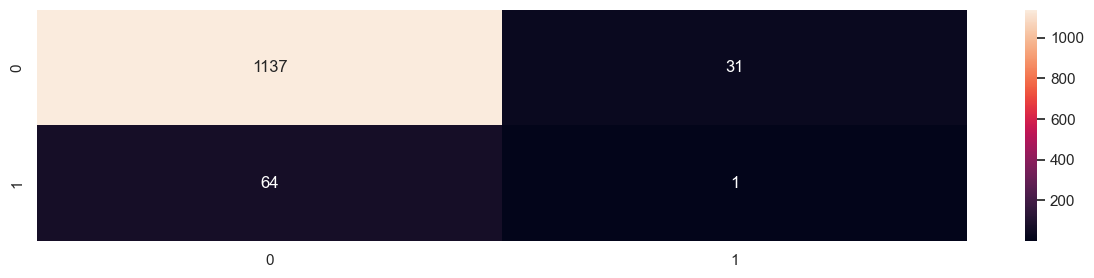

In [434]:
model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)
predicted = model.predict(normalized_x_test)
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
sns.heatmap(matrix, annot= True, fmt = 'd')
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))

The confusion matrix for the best model provides:
Precision score: 0.176
Recall score: 0.046
F1 score: 0.073


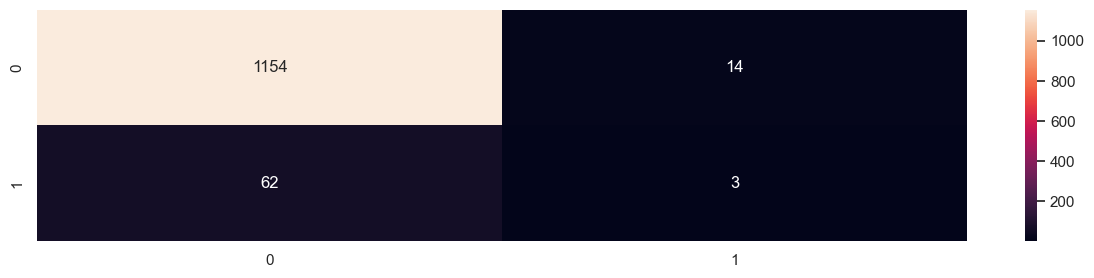

In [435]:
model =  xgb.XGBClassifier()
model.fit(X_resampled, y_resampled)
predicted = model.predict(normalized_x_test)
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
sns.heatmap(matrix, annot= True, fmt = 'd')
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))

[LightGBM] [Info] Number of positive: 4669, number of negative: 4669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 9338, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
The confusion matrix for the best model provides:
Precision score: 0.375
Recall score: 0.046
F1 score: 0.082


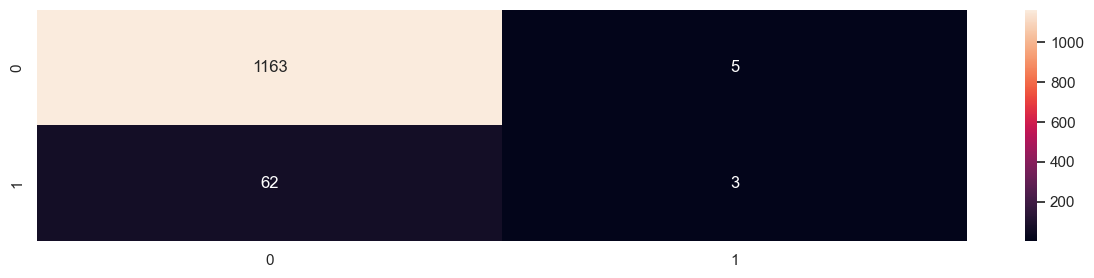

In [436]:
model =  ltb.LGBMClassifier()
model.fit(X_resampled, y_resampled)
predicted = model.predict(normalized_x_test)
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
sns.heatmap(matrix, annot= True, fmt = 'd')
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))

The confusion matrix for the best model provides:
Precision score: 0.063
Recall score: 0.569
F1 score: 0.113


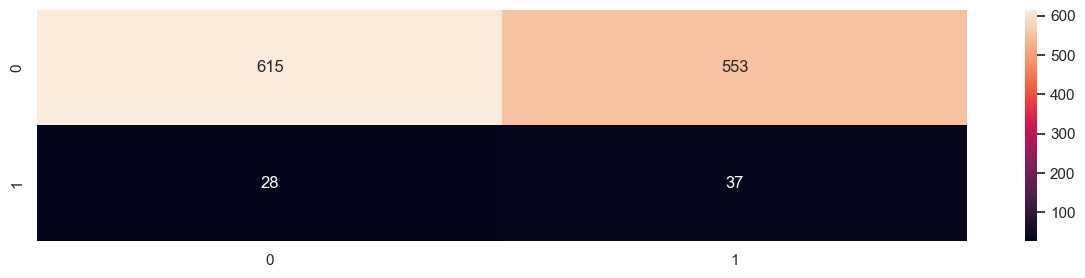

In [437]:
#Let's also try Logistic Regression as a last resort 
# This is my last resort...
model =  LogisticRegression()
model.fit(X_resampled, y_resampled)
predicted = model.predict(normalized_x_test)
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
sns.heatmap(matrix, annot= True, fmt = 'd')
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))

#### Hyperparameter tuning and finalizing models again 

In [438]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Print the best F1 score
print("Best F1 Score:", grid_search.best_score_)

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best F1 Score: 0.9594144999808101


The confusion matrix for the best model provides:
Precision score: 0.056
Recall score: 0.015
F1 score: 0.024


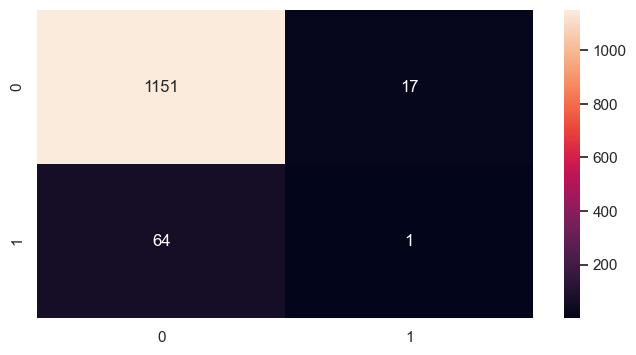

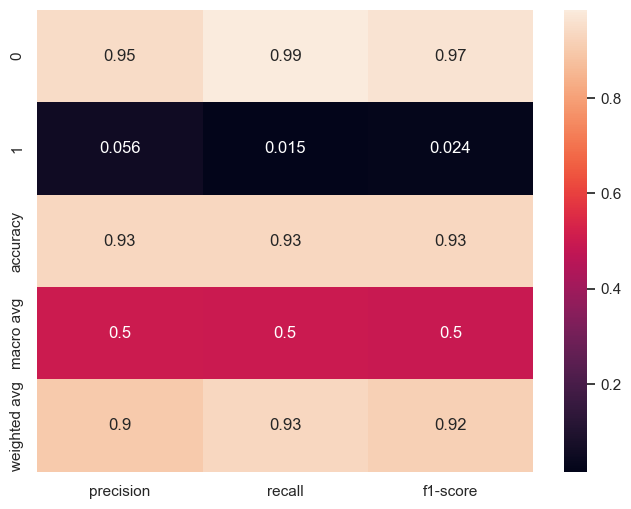

In [444]:
model = RandomForestClassifier(bootstrap= False, max_depth= None, min_samples_leaf= 2, min_samples_split= 10, n_estimators= 100,random_state=42)
model.fit(X_resampled, y_resampled)
predicted = model.predict(normalized_x_test)
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
plt.figure(figsize=(8,4))
sns.heatmap(matrix, annot= True, fmt = 'd')
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))
plt.figure(figsize=(8,6))
clas_rep(y_test, predicted)

In [445]:
# Define the parameter distributions for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [1, 1.1, 1.2]
}

lgb_classifier = xgb.XGBClassifier( random_state=42)

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(lgb_classifier, param_distributions=param_grid,
                                   scoring='f1', cv=5, n_iter=10, n_jobs=-1, random_state=42)

# Fit the randomized search to the data
random_search.fit(X_resampled, y_resampled)

# Print the best parameters
print("Best Parameters:", random_search.best_params_)

# Print the best F1 score
print("Best F1 Score:", random_search.best_score_)

Best Parameters: {'subsample': 0.8, 'reg_lambda': 1.1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best F1 Score: 0.957125474925584


The confusion matrix for the best model provides:
Precision score: 0.250
Recall score: 0.031
F1 score: 0.055


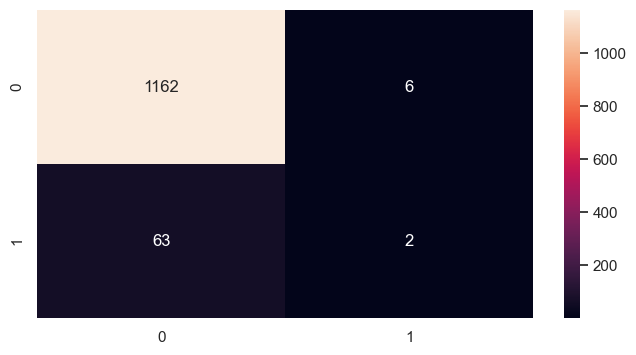

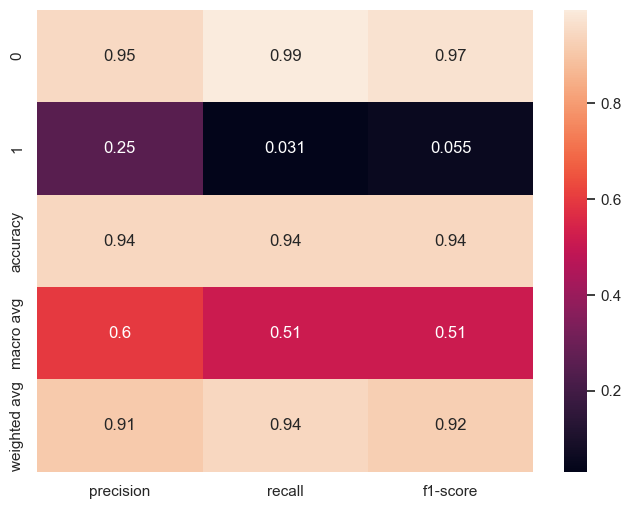

In [446]:
model = xgb.XGBClassifier(subsample= 0.8, reg_lambda= 1.1, reg_alpha= 0, n_estimators= 200, min_child_weight= 1, max_depth= 5, learning_rate= 0.1, gamma= 0.2, colsample_bytree= 0.9)
model.fit(X_resampled, y_resampled)
predicted = model.predict(normalized_x_test)
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
plt.figure(figsize=(8,4))
sns.heatmap(matrix, annot= True, fmt = 'd')
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))
plt.figure(figsize=(8,6))
clas_rep(y_test, predicted)

In [451]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, -1],  # -1 means no limit
    'num_leaves': [31, 63, 127],
    'min_child_samples': [1, 5, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2]
}

# Create a LightGBM classifier
lgb_classifier = ltb.LGBMClassifier( random_state=42)

# Instantiate GridSearchCV or RandomizedSearchCV
# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(lgb_classifier, param_distributions=param_grid,
                                   scoring='f1', cv=5, n_iter=10, n_jobs=-1, random_state=42)


# Fit the grid search to the data
random_search.fit(X_resampled, y_resampled)

# Print the best parameters
print("Best Parameters:", random_search.best_params_)

# Print the best F1 score
print("Best F1 Score:", random_search.best_score_)

[LightGBM] [Info] Number of positive: 4669, number of negative: 4669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 9338, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.2, 'reg_alpha': 0.1, 'num_leaves': 63, 'n_estimators': 50, 'min_child_samples': 5, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best F1 Score: 0.9603570987201022


[LightGBM] [Info] Number of positive: 4669, number of negative: 4669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 9338, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


The confusion matrix for the best model provides:
Precision score: 0.200
Recall score: 0.031
F1 score: 0.053


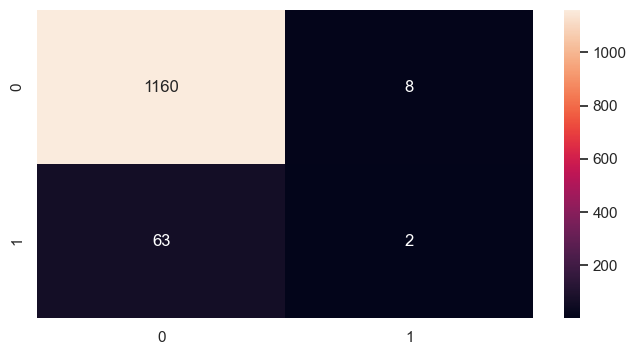

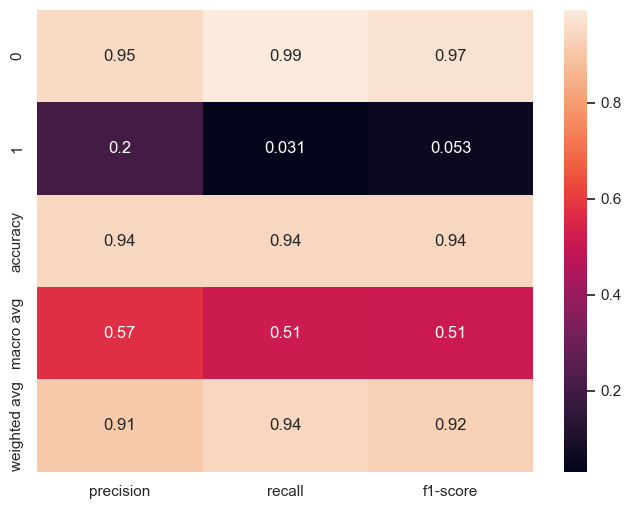

In [467]:
model = ltb.LGBMClassifier(subsample= 1.0, reg_lambda= 0.2, reg_alpha= 0.1, num_leaves= 63, n_estimators= 50, min_child_samples= 5, max_depth= -1, learning_rate= 0.1, colsample_bytree= 0.8,random_state = 17)
model.fit(X_resampled, y_resampled)
predicted = model.predict(normalized_x_test)
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
plt.figure(figsize=(8,4))
sns.heatmap(matrix, annot= True, fmt = 'd')
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))
plt.figure(figsize=(8,6))
clas_rep(y_test, predicted)

Even though our best models performed well during training with oversampling, their F1 scores dropped significantly during testing as oversampling couldn't be applied to the test set, which mirrors real-world scenarios. Surprisingly, Logistic Regression, despite not being the top performer in training, showed a higher F1 score during testing. However, it also misclassified more data, as seen in the confusion matrix where we compare the best 2 methods. To address potential overfitting, our next steps include exploring feature reduction as we did before and adjusting tree depth to improve generalizability.

Best models

[LightGBM] [Info] Number of positive: 4669, number of negative: 4669
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 9338, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
The confusion matrix for the best model provides:
Precision score: 0.375
Recall score: 0.046
F1 score: 0.082


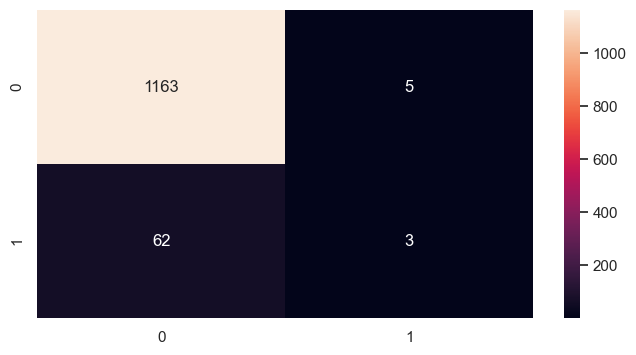

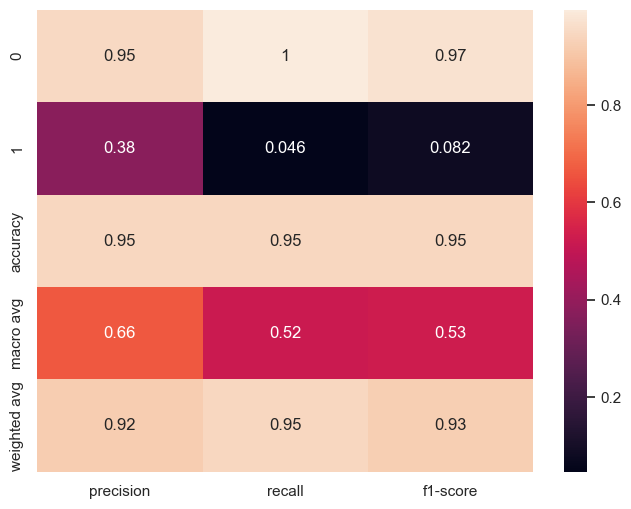

In [486]:
model =  ltb.LGBMClassifier()
model.fit(X_resampled, y_resampled)
predicted = model.predict(normalized_x_test)
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
plt.figure(figsize=(8,4))
sns.heatmap(matrix, annot= True, fmt = 'd')
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))
plt.figure(figsize=(8,6))
clas_rep(y_test, predicted)

 auc=0.089 ap=0.068


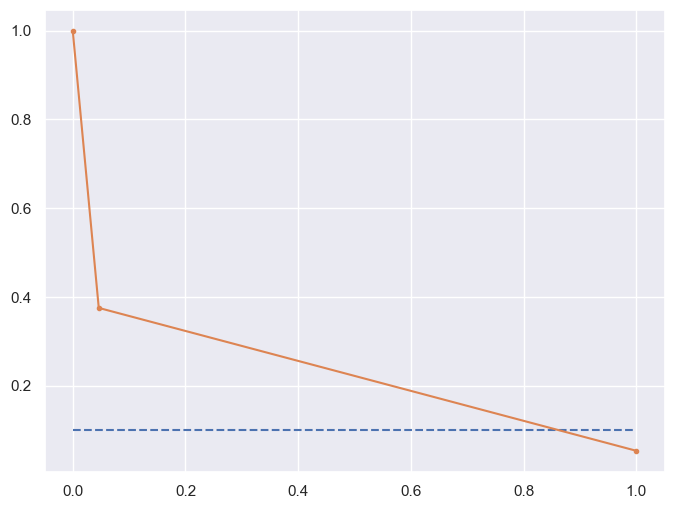

In [471]:
# prec_rec_curve(y_test.values, predicted,"RandomForestClassifier")
precision, recall, thresholds = precision_recall_curve(y_test.values, predicted)
# calculate F1 score
# calculate precision-recall AUC
# auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test.values, predicted)
print(' auc=%.3f ap=%.3f' % (auc, ap))
# plot no skill
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0.1, 0.1], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

AUC: 0.521


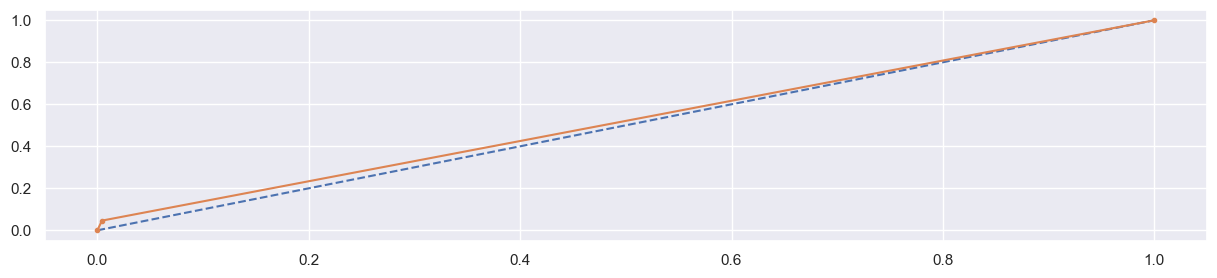

In [472]:
# auc_score(y_test.values, predicted)
# calculate AUC
auc = roc_auc_score(y_test.values, predicted)
print('AUC: %.3f' % auc)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test.values, predicted)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')

# show the plot
plt.show()

In [473]:
# let's also try to optimize logistic regression
param_grid = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear','lbfgs','newton-cg','sag','saga']}
model = LogisticRegression()
# run grid search
random_search = RandomizedSearchCV(model, param_distributions=param_grid, cv=5, scoring='f1',random_state = 42)
random_search.fit(X_resampled, y_resampled)
# print(random_search.cv_results_)
print("Best parameter (CV score=%0.3f):" % random_search.best_score_)
print(random_search.best_params_)

Best parameter (CV score=0.566):
{'solver': 'saga', 'penalty': 'l2', 'C': 0.03359818286283781}


The confusion matrix for the best model provides:
The accuracy in the test data is: 0.535
Precision score: 0.071
Recall score: 0.646
F1 score: 0.128


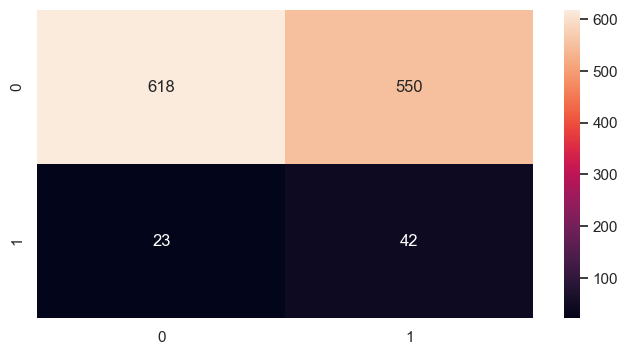

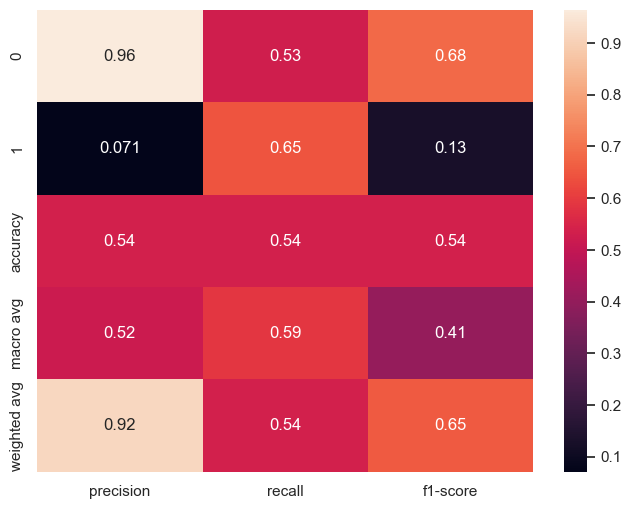

In [487]:
model =  LogisticRegression(solver= 'saga', penalty= 'l2', C= 0.03359818286283781)
model.fit(X_resampled, y_resampled)
predicted = model.predict(normalized_x_test)
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
plt.figure(figsize=(8,4))
sns.heatmap(matrix, annot= True, fmt = 'd')
accuracy = accuracy_score(y_test, predicted)
print("The accuracy in the test data is: %0.3f" % accuracy)
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))
plt.figure(figsize=(8,6))
clas_rep(y_test, predicted)

 auc=0.521 ap=0.064


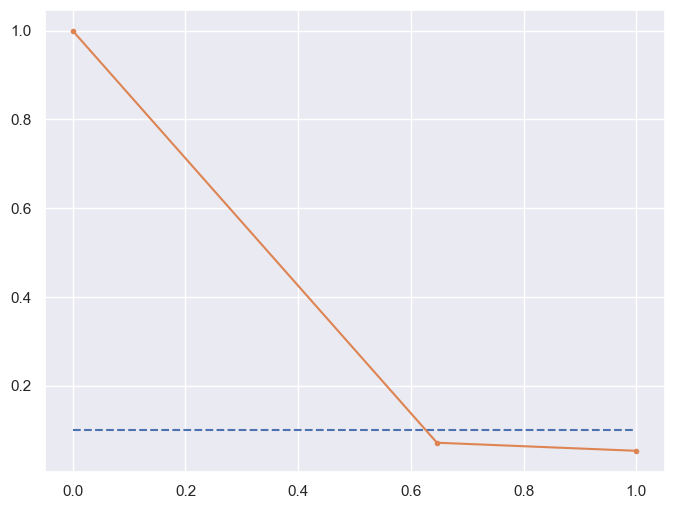

In [476]:
# prec_rec_curve(y_test.values, predicted,"RandomForestClassifier")
precision, recall, thresholds = precision_recall_curve(y_test.values, predicted)
# calculate F1 score
# calculate precision-recall AUC
# auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test.values, predicted)
print(' auc=%.3f ap=%.3f' % (auc, ap))
# plot no skill
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0.1, 0.1], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

AUC: 0.588


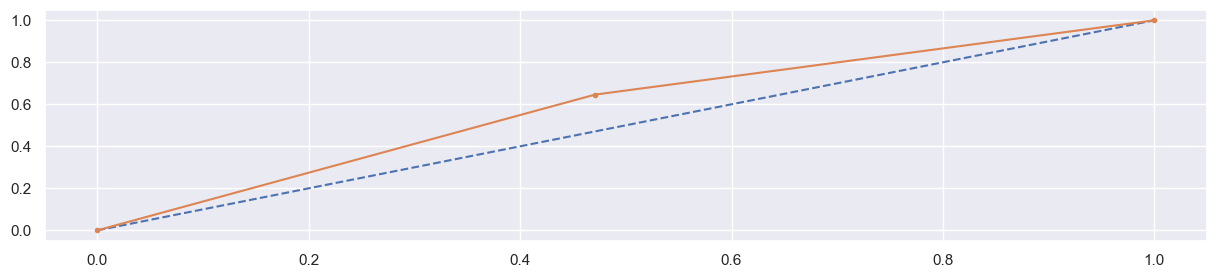

In [477]:
# auc_score(y_test.values, predicted)
# calculate AUC
auc = roc_auc_score(y_test.values, predicted)
print('AUC: %.3f' % auc)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test.values, predicted)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')

# show the plot
plt.show()

Now, let's also try to the previous models, and try methods to address potential overfitting. One way to fix f1 could be by reducing some features.


The confusion matrix for the best model provides:
Precision score: 0.029
Recall score: 0.015
F1 score: 0.020


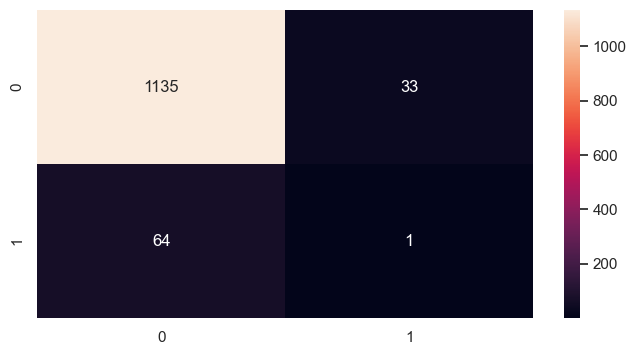

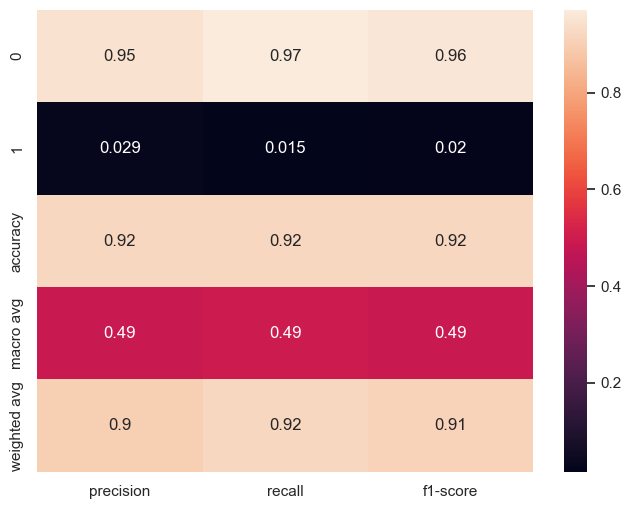

In [478]:
# let's try it in 
model = xgb.XGBClassifier()
model.fit(X_resampled[selected_features_2], y_resampled)
predicted = model.predict(normalized_x_test[selected_features_2])
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
plt.figure(figsize=(8,4))
sns.heatmap(matrix, annot= True, fmt = 'd')
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))
plt.figure(figsize=(8,6))
clas_rep(y_test, predicted)

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [5,10,50, 100, 200],
    'max_depth': [2,3,4,5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Instantiate GridSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, scoring='f1', cv=5, n_jobs=-1,random_state = 42)

# Fit the grid search to the data
random_search.fit(X_resampled[selected_features_2], y_resampled)

# Print the best parameters
print("Best Parameters:", random_search.best_params_)

# Print the best F1 score
print("Best F1 Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
Best F1 Score: 0.935354996932328


The confusion matrix for the best model provides:
Precision score: 0.057
Recall score: 0.031
F1 score: 0.040


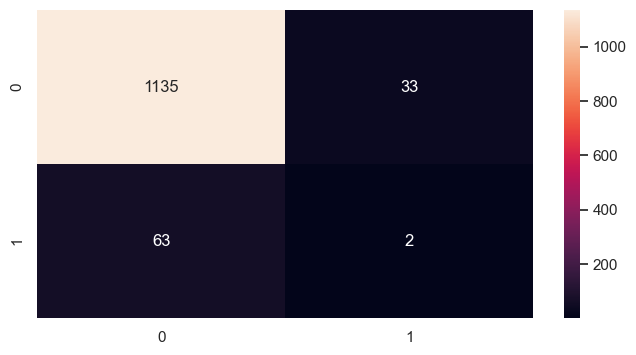

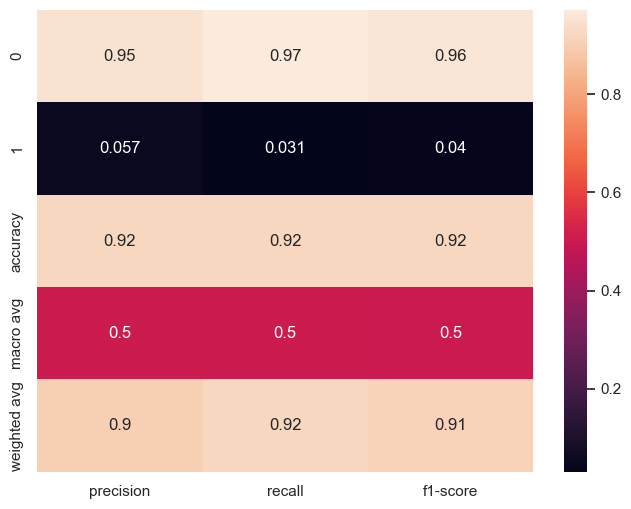

In [ ]:
model = RandomForestClassifier(n_estimators= 50, min_samples_split= 10, min_samples_leaf= 1, max_depth= 20, bootstrap= False,random_state=42)
model.fit(X_resampled[selected_features_2], y_resampled)
predicted = model.predict(normalized_x_test[selected_features_2])
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
plt.figure(figsize=(8,4))
sns.heatmap(matrix, annot= True, fmt = 'd')
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))
plt.figure(figsize=(8,6))
clas_rep(y_test, predicted)

In [ ]:
# let's also try to optimize logistic regression
param_grid = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear','lbfgs','newton-cg','sag','saga']}
model = LogisticRegression()
# run grid search
random_search = RandomizedSearchCV(model, param_distributions=param_grid, cv=5, scoring='f1',random_state = 42)
random_search.fit(X_resampled[selected_features_2], y_resampled)
# print(random_search.cv_results_)
print("Best parameter (CV score=%0.3f):" % random_search.best_score_)
print(random_search.best_params_)

Best parameter (CV score=0.530):
{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.615848211066026}


The confusion matrix for the best model provides:
The accuracy in the test data is: 0.505
Precision score: 0.055
Recall score: 0.523
F1 score: 0.100


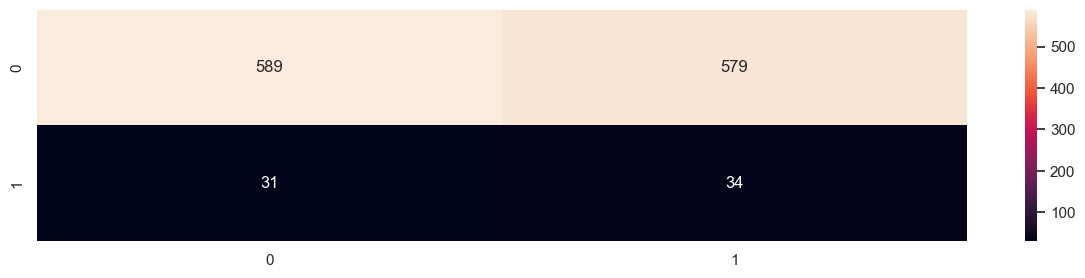

In [ ]:
model =  LogisticRegression(solver= 'liblinear', penalty= 'l2', C= 0.615848211066026)
model.fit(X_resampled[selected_features_2], y_resampled)
predicted = model.predict(normalized_x_test[selected_features_2])
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
sns.heatmap(matrix, annot= True, fmt = 'd')
accuracy = accuracy_score(y_test, predicted)
print("The accuracy in the test data is: %0.3f" % accuracy)
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))

Finally let's also try to reduce max depth where possible like in Random Forest.

The confusion matrix for the best model provides:
Precision score: 0.062
Recall score: 0.492
F1 score: 0.111


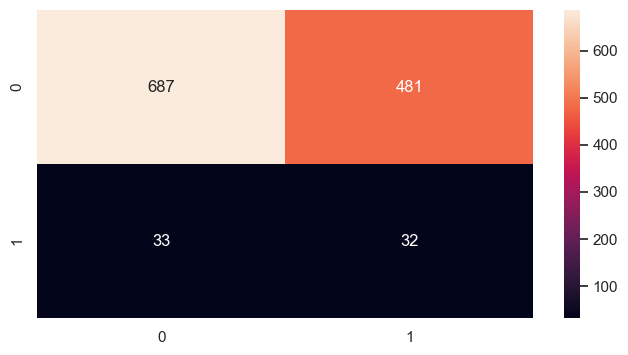

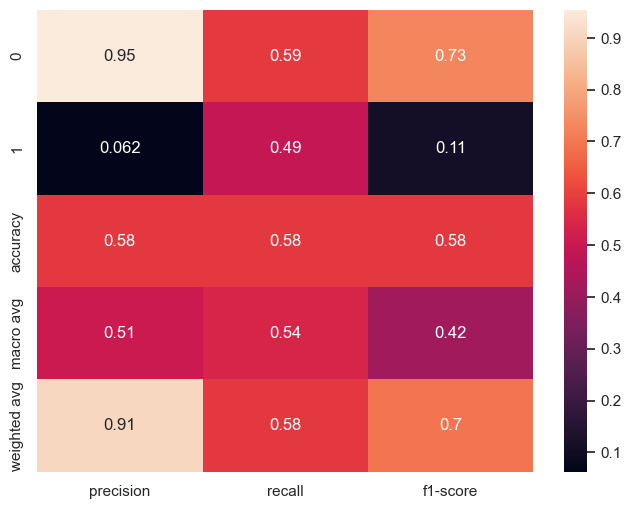

In [481]:
model = RandomForestClassifier(bootstrap= False, max_depth=2, min_samples_leaf= 2, min_samples_split= 10, n_estimators= 100,random_state=42)
model.fit(X_resampled, y_resampled)
predicted = model.predict(normalized_x_test)
matrix = confusion_matrix(y_test, predicted)
print("The confusion matrix for the best model provides:")
plt.figure(figsize=(8,4))
sns.heatmap(matrix, annot= True, fmt = 'd')
precision= precision_score(y_test, predicted)
print('Precision score: {0:0.3f}'.format(precision))
recall = recall_score(y_test, predicted)
print('Recall score: {0:0.3f}'.format(recall))
f1 = f1_score(y_test, predicted)
print('F1 score: {0:0.3f}'.format(f1))
plt.figure(figsize=(8,6))
clas_rep(y_test, predicted)

 auc=0.588 ap=0.057


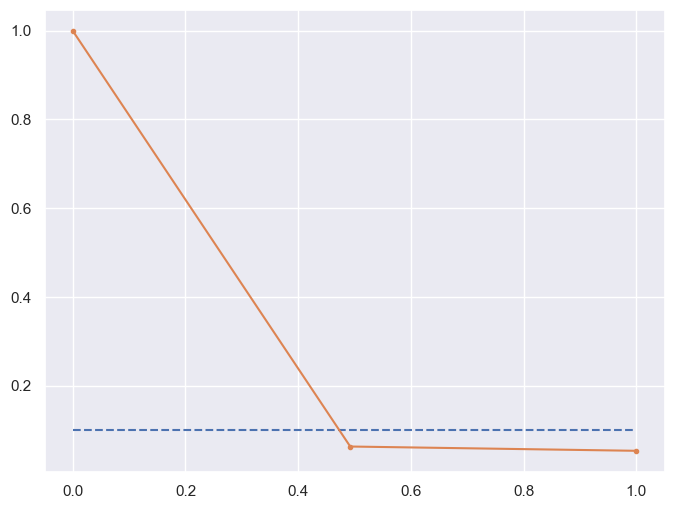

In [482]:
# prec_rec_curve(y_test.values, predicted,"RandomForestClassifier")
precision, recall, thresholds = precision_recall_curve(y_test.values, predicted)
# calculate F1 score
# calculate precision-recall AUC
# auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test.values, predicted)
print(' auc=%.3f ap=%.3f' % (auc, ap))
# plot no skill
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0.1, 0.1], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

AUC: 0.540


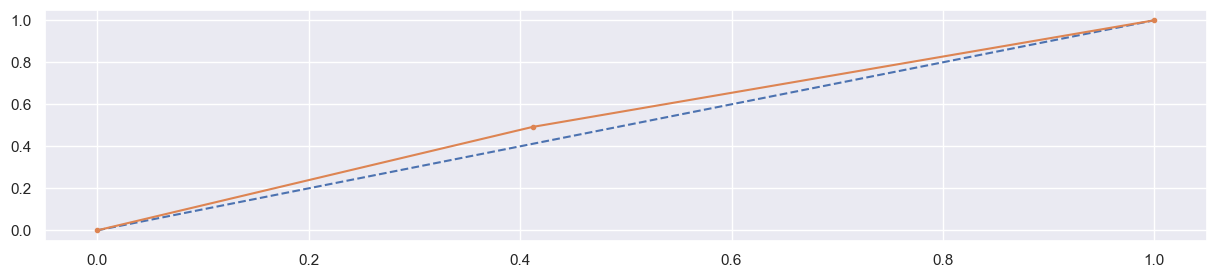

In [483]:
# auc_score(y_test.values, predicted)
# calculate AUC
auc = roc_auc_score(y_test.values, predicted)
print('AUC: %.3f' % auc)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test.values, predicted)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')

# show the plot
plt.show()

It appears that despite our best efforts, even after several attempts to overcome the imbalance issue, including normalization,oversampling, feature selection, stratifiedkfold cross validation, appropriate choice of metric (f1) and hyperparameter tuning, we were still not able to get a good ROC AUC curve in this case. Sometimes the data is just too imbalanced. 